In [1]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


In [4]:
def plot_magn(magn):
    scaled = magn ** 0.1
    plot(scaled / torch.max(scaled))
    
def plot_phase(phase):
    plot((phase + math.pi) / (2 * math.pi))

fashion


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


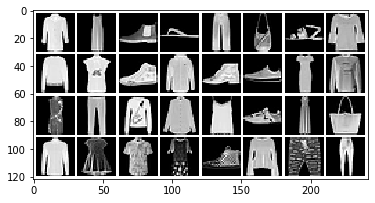

torch.Size([32, 1, 28, 28])


In [5]:
### LOAD DATA ###

dataset = 'fashion'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft ** 2, -1))
sample_phases = torch.atan2(sample_ft[..., 1], sample_ft[..., 0])

plot_grid(sample)
print(sample_magnitudes.shape)

Magnitude:


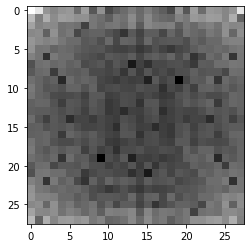

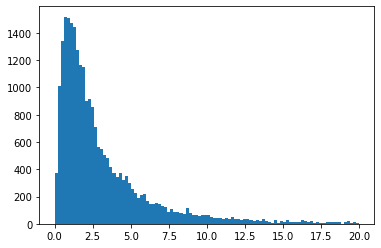

Phase:


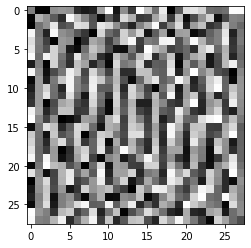

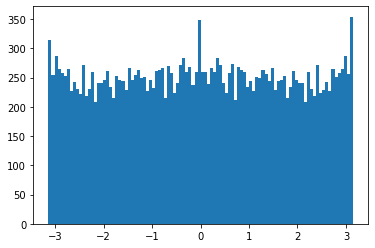

In [6]:
# Value distributions of magnitude and phase for the first sample

print("Magnitude:")
plot_magn(sample_magnitudes[0, 0])
plt.hist(sample_magnitudes.reshape(-1), bins=100, range=(0, 20))
plt.show()
print("Phase:")
plot_phase(sample_phases[0, 0])
plt.hist(sample_phases.reshape(-1), bins=100)
plt.show()

In [7]:
# Check for shapes of rfft transformation in Fourier and signal domain

sample_ft1 = torch.rfft(sample, 2, onesided=True)
print(sample_ft1.shape)
sample1 = torch.irfft(sample_ft1, 2, onesided=True, signal_sizes=(28, 28))
print(sample1[0].shape)

torch.Size([32, 1, 28, 15, 2])
torch.Size([1, 28, 28])


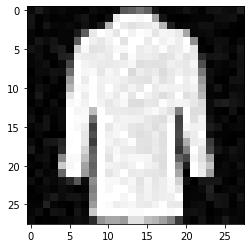

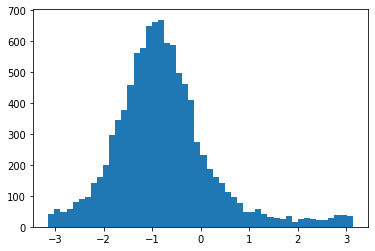

In [8]:
# Show how a small change in the signal space can disturb a specific phase
noise_level = 0.05
########
plot(sample[0] + noise_level * torch.abs(torch.randn(sample[0].shape)))

ph0 = []
for i in range(10000):
    ft = torch.rfft(sample[0] + noise_level * torch.randn(sample[0].shape), 2, onesided=True)
    ph0.append(torch.atan2(ft[..., 1], ft[..., 0])[0, 10, 10])
    
plt.hist(ph0, bins=50)
plt.show()

Gaussian in the signal domain cause Gaussian noise for the phases. But circular!

---

In [9]:
# Define different distances (expecting real phases)

def l2(phase1, phase2):
    return torch.mean((phase1 - phase2) ** 2)

def cmplx_l2(magn, phase1, phase2):
    vec1 = torch.stack([torch.cos(phase1), torch.sin(phase1)], dim=-1)
    vec2 = torch.stack([torch.cos(phase2), torch.sin(phase2)], dim=-1)
    return torch.mean((magn ** 2) * torch.sum((vec1 - vec2) ** 2, -1))

# equals cmpls_l2 for magn = 1
def fourier_l2(magn, phase1, phase2):
    return 2 * torch.mean((magn ** 2) * (1 - torch.cos(phase1 - phase2)))

Sample 1


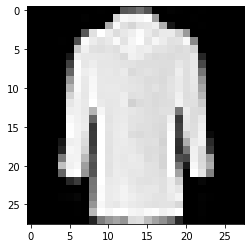

Sample 1 with small noise


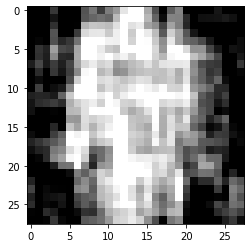

Sample 1 noise vs. Sample 1
Real L2 47.712738037109375
###########################
L2 5.634765625
Cmplx L2 47.712730407714844
Fourier L2 47.712738037109375


In [10]:
sample1 = sample[0]

sample1_ft = torch.rfft(sample1, 2, onesided=False)
sample1_phases = torch.atan2(sample1_ft[..., 1], sample1_ft[..., 0])
sample1_magn = torch.norm(sample1_ft, dim=-1)

sample1_noise = sample1 + 1.0 * torch.randn(sample1.shape)
sample1_noise_ft = torch.rfft(sample1_noise, 2, onesided=False)
sample1_noise_ft = sample1_magn[..., None] * (sample1_noise_ft /
                                              torch.sqrt(torch.sum(sample1_noise_ft ** 2, -1))[..., None])

sample1_noise_phases = torch.atan2(sample1_noise_ft[..., 1], sample1_noise_ft[..., 0])
sample1_noise = torch.irfft(sample1_noise_ft, 2, onesided=False)

print("Sample 1")
plot(sample1)

print("Sample 1 with small noise")
plot(sample1_noise)


print("Sample 1 noise vs. Sample 1")
print("Real L2", torch.sum((sample1 - sample1_noise) ** 2).item())
print("###########################")
print("L2", l2(sample1_phases, sample1_noise_phases).item())
print("Cmplx L2", cmplx_l2(sample1_magn, sample1_phases, sample1_noise_phases).item())
print("Fourier L2", fourier_l2(sample1_magn, sample1_phases, sample1_noise_phases).item())

In [11]:
# Fully connected image network
class FCNet(nn.Module):

    __constants__ = ['mean', 'std']

    def __init__(self, imsize=(1, 28, 28), outsize=None, h=2048, mean=None, std=None):
        super(FCNet, self).__init__()
        print("Version 0.4")
        self.imsize = imsize
        if outsize is None:
            self.outsize = imsize
        else:
            self.outsize = outsize
        
        if mean is None:
            self.register_buffer('mean', torch.zeros(imsize))
        else:
            self.register_buffer('mean', torch.Tensor(mean))

        if std is None:
            self.register_buffer('std', torch.ones(imsize))
        else:
            self.register_buffer('std', torch.Tensor(std))
        
        self.layers = nn.Sequential(
            nn.Linear(imsize[0] * imsize[1] * imsize[2], h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h, self.outsize[0] * self.outsize[1] * self.outsize[2]),
            nn.Tanh()
        )
        
    def forward(self, x):
    
        N = x.shape[0]

        out = math.pi * self.layers(x.view(N, -1))
        return out.view(N, *self.outsize)

In [12]:
def calc_fourier(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    phs = torch.atan2(ft[..., 1], ft[..., 0])
    return mags, phs

In [13]:
# Define loss

def gen_loss(magn, phase1, phase2):
    return 2 * torch.mean((magn ** 2) * (1 - torch.cos(phase1 - phase2)))
    #return torch.mean((phase1 - phase2) ** 2)

In [14]:
### Create new models ###

gen = FCNet(imsize=(1, 28, 28), outsize=(1, 28, 28), h=2048)

Version 0.4


In [15]:
# Set training parameters

history = []
opt = optim.Adam(gen.parameters(), lr=1e-3)

In [16]:
# Initial loss

gen = gen.to(device)
sample = sample.to(device)
sample_magn, sample_phs = calc_fourier(sample)

pred_phs = gen(sample_magn)

loss = gen_loss(sample_magn, pred_phs, sample_phs)

print("Generator loss:", loss.item())

Generator loss: 257.7100524902344


In [17]:
def train_model(model, optimizer, device, loader_train, epochs=1):

    # move the model parameters to CPU/GPU
    model = model.to(device=device)
    
    history = []
    
    for e in range(epochs):

        for t, x in enumerate(loader_train):
            # put model to training mode
            model.train()
            
            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)

            magn, phs = calc_fourier(x)

            # compute loss as pixel wise distance to original input
            pred_phs = model(magn)
            
            loss = gen_loss(magn, pred_phs, phs)
            #loss = torch.mean((x - out_real)**2) + torch.mean((phases - out_phases)**2)
            history.append(loss.item())

            # perform backprop and learning step
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4}".format(e+1, t, history[-1]))
                
        plt.plot(history)
        plt.show()
                
    return history

epoch:  1 	 step:0 	 loss: 234.7
epoch:  1 	 step:100 	 loss: 44.48
epoch:  1 	 step:200 	 loss: 48.85
epoch:  1 	 step:300 	 loss: 44.7
epoch:  1 	 step:400 	 loss: 46.77
epoch:  1 	 step:500 	 loss: 50.19
epoch:  1 	 step:600 	 loss: 44.91
epoch:  1 	 step:700 	 loss: 43.24
epoch:  1 	 step:800 	 loss: 37.02
epoch:  1 	 step:900 	 loss: 36.39
epoch:  1 	 step:1000 	 loss: 51.01
epoch:  1 	 step:1100 	 loss: 46.37
epoch:  1 	 step:1200 	 loss: 37.33
epoch:  1 	 step:1300 	 loss: 54.36
epoch:  1 	 step:1400 	 loss: 36.89
epoch:  1 	 step:1500 	 loss: 37.06
epoch:  1 	 step:1600 	 loss: 41.88
epoch:  1 	 step:1700 	 loss: 34.64
epoch:  1 	 step:1800 	 loss: 36.84


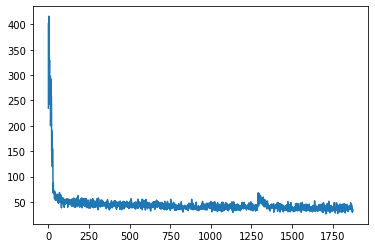

epoch:  2 	 step:0 	 loss: 29.1
epoch:  2 	 step:100 	 loss: 34.64
epoch:  2 	 step:200 	 loss: 39.17
epoch:  2 	 step:300 	 loss: 40.19
epoch:  2 	 step:400 	 loss: 41.33
epoch:  2 	 step:500 	 loss: 35.62
epoch:  2 	 step:600 	 loss: 50.47
epoch:  2 	 step:700 	 loss: 28.78
epoch:  2 	 step:800 	 loss: 49.86
epoch:  2 	 step:900 	 loss: 39.39
epoch:  2 	 step:1000 	 loss: 39.7
epoch:  2 	 step:1100 	 loss: 37.76
epoch:  2 	 step:1200 	 loss: 31.49
epoch:  2 	 step:1300 	 loss: 31.81
epoch:  2 	 step:1400 	 loss: 31.38
epoch:  2 	 step:1500 	 loss: 40.65
epoch:  2 	 step:1600 	 loss: 35.38
epoch:  2 	 step:1700 	 loss: 32.59
epoch:  2 	 step:1800 	 loss: 34.51


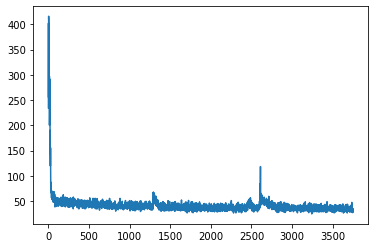

epoch:  3 	 step:0 	 loss: 38.91
epoch:  3 	 step:100 	 loss: 34.92
epoch:  3 	 step:200 	 loss: 35.31
epoch:  3 	 step:300 	 loss: 30.61
epoch:  3 	 step:400 	 loss: 43.06
epoch:  3 	 step:500 	 loss: 39.73
epoch:  3 	 step:600 	 loss: 35.58
epoch:  3 	 step:700 	 loss: 40.46
epoch:  3 	 step:800 	 loss: 41.08
epoch:  3 	 step:900 	 loss: 37.63
epoch:  3 	 step:1000 	 loss: 39.09
epoch:  3 	 step:1100 	 loss: 38.07
epoch:  3 	 step:1200 	 loss: 36.13
epoch:  3 	 step:1300 	 loss: 31.89
epoch:  3 	 step:1400 	 loss: 31.95
epoch:  3 	 step:1500 	 loss: 40.38
epoch:  3 	 step:1600 	 loss: 28.24
epoch:  3 	 step:1700 	 loss: 30.19
epoch:  3 	 step:1800 	 loss: 26.78


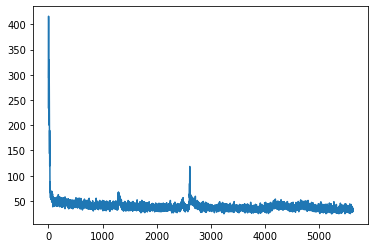

epoch:  4 	 step:0 	 loss: 25.79
epoch:  4 	 step:100 	 loss: 42.31
epoch:  4 	 step:200 	 loss: 33.87
epoch:  4 	 step:300 	 loss: 34.25
epoch:  4 	 step:400 	 loss: 30.78
epoch:  4 	 step:500 	 loss: 36.66
epoch:  4 	 step:600 	 loss: 52.47
epoch:  4 	 step:700 	 loss: 34.12
epoch:  4 	 step:800 	 loss: 33.36
epoch:  4 	 step:900 	 loss: 34.33
epoch:  4 	 step:1000 	 loss: 33.87
epoch:  4 	 step:1100 	 loss: 33.69
epoch:  4 	 step:1200 	 loss: 31.6
epoch:  4 	 step:1300 	 loss: 34.34
epoch:  4 	 step:1400 	 loss: 25.42
epoch:  4 	 step:1500 	 loss: 35.95
epoch:  4 	 step:1600 	 loss: 28.39
epoch:  4 	 step:1700 	 loss: 27.46
epoch:  4 	 step:1800 	 loss: 33.93


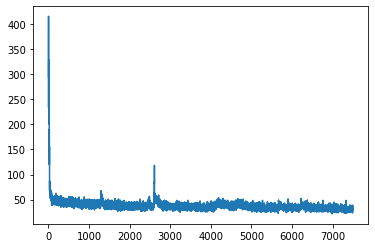

epoch:  5 	 step:0 	 loss: 30.96
epoch:  5 	 step:100 	 loss: 34.09
epoch:  5 	 step:200 	 loss: 39.08
epoch:  5 	 step:300 	 loss: 28.12
epoch:  5 	 step:400 	 loss: 35.3
epoch:  5 	 step:500 	 loss: 26.49
epoch:  5 	 step:600 	 loss: 28.8
epoch:  5 	 step:700 	 loss: 27.31
epoch:  5 	 step:800 	 loss: 29.99
epoch:  5 	 step:900 	 loss: 33.29
epoch:  5 	 step:1000 	 loss: 26.08
epoch:  5 	 step:1100 	 loss: 26.11
epoch:  5 	 step:1200 	 loss: 28.01
epoch:  5 	 step:1300 	 loss: 30.08
epoch:  5 	 step:1400 	 loss: 23.48
epoch:  5 	 step:1500 	 loss: 29.09
epoch:  5 	 step:1600 	 loss: 29.95
epoch:  5 	 step:1700 	 loss: 32.11
epoch:  5 	 step:1800 	 loss: 28.8


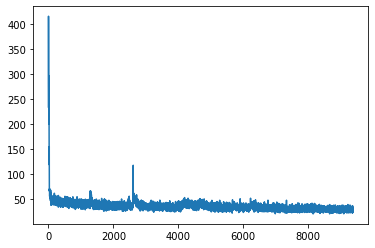

epoch:  6 	 step:0 	 loss: 32.34
epoch:  6 	 step:100 	 loss: 27.99
epoch:  6 	 step:200 	 loss: 31.95
epoch:  6 	 step:300 	 loss: 28.22
epoch:  6 	 step:400 	 loss: 26.77
epoch:  6 	 step:500 	 loss: 32.29
epoch:  6 	 step:600 	 loss: 31.04
epoch:  6 	 step:700 	 loss: 33.47
epoch:  6 	 step:800 	 loss: 25.21
epoch:  6 	 step:900 	 loss: 32.65
epoch:  6 	 step:1000 	 loss: 27.11
epoch:  6 	 step:1100 	 loss: 28.45
epoch:  6 	 step:1200 	 loss: 28.13
epoch:  6 	 step:1300 	 loss: 29.29
epoch:  6 	 step:1400 	 loss: 31.0
epoch:  6 	 step:1500 	 loss: 28.33
epoch:  6 	 step:1600 	 loss: 27.24
epoch:  6 	 step:1700 	 loss: 26.49
epoch:  6 	 step:1800 	 loss: 27.4


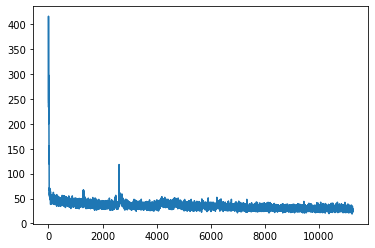

epoch:  7 	 step:0 	 loss: 32.08
epoch:  7 	 step:100 	 loss: 26.66
epoch:  7 	 step:200 	 loss: 26.2
epoch:  7 	 step:300 	 loss: 31.57
epoch:  7 	 step:400 	 loss: 28.46
epoch:  7 	 step:500 	 loss: 31.76
epoch:  7 	 step:600 	 loss: 29.98
epoch:  7 	 step:700 	 loss: 31.9
epoch:  7 	 step:800 	 loss: 26.02
epoch:  7 	 step:900 	 loss: 31.93
epoch:  7 	 step:1000 	 loss: 23.36
epoch:  7 	 step:1100 	 loss: 21.63
epoch:  7 	 step:1200 	 loss: 32.28
epoch:  7 	 step:1300 	 loss: 27.72
epoch:  7 	 step:1400 	 loss: 30.33
epoch:  7 	 step:1500 	 loss: 30.53
epoch:  7 	 step:1600 	 loss: 32.63
epoch:  7 	 step:1700 	 loss: 33.39
epoch:  7 	 step:1800 	 loss: 27.91


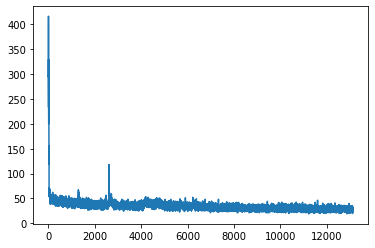

epoch:  8 	 step:0 	 loss: 27.13
epoch:  8 	 step:100 	 loss: 28.74
epoch:  8 	 step:200 	 loss: 24.71
epoch:  8 	 step:300 	 loss: 24.7
epoch:  8 	 step:400 	 loss: 28.88
epoch:  8 	 step:500 	 loss: 29.54
epoch:  8 	 step:600 	 loss: 34.55
epoch:  8 	 step:700 	 loss: 37.58
epoch:  8 	 step:800 	 loss: 24.89
epoch:  8 	 step:900 	 loss: 28.97
epoch:  8 	 step:1000 	 loss: 28.49
epoch:  8 	 step:1100 	 loss: 33.75
epoch:  8 	 step:1200 	 loss: 23.1
epoch:  8 	 step:1300 	 loss: 27.96
epoch:  8 	 step:1400 	 loss: 24.22
epoch:  8 	 step:1500 	 loss: 34.31
epoch:  8 	 step:1600 	 loss: 32.92
epoch:  8 	 step:1700 	 loss: 26.89
epoch:  8 	 step:1800 	 loss: 28.25


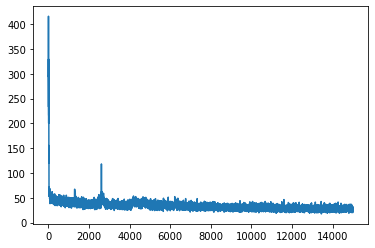

epoch:  9 	 step:0 	 loss: 32.04
epoch:  9 	 step:100 	 loss: 22.14
epoch:  9 	 step:200 	 loss: 28.45
epoch:  9 	 step:300 	 loss: 22.03
epoch:  9 	 step:400 	 loss: 23.68
epoch:  9 	 step:500 	 loss: 28.38
epoch:  9 	 step:600 	 loss: 30.74
epoch:  9 	 step:700 	 loss: 30.13
epoch:  9 	 step:800 	 loss: 24.02
epoch:  9 	 step:900 	 loss: 27.39
epoch:  9 	 step:1000 	 loss: 36.41
epoch:  9 	 step:1100 	 loss: 20.61
epoch:  9 	 step:1200 	 loss: 32.81
epoch:  9 	 step:1300 	 loss: 26.95
epoch:  9 	 step:1400 	 loss: 25.36
epoch:  9 	 step:1500 	 loss: 23.47
epoch:  9 	 step:1600 	 loss: 28.75
epoch:  9 	 step:1700 	 loss: 23.1
epoch:  9 	 step:1800 	 loss: 25.42


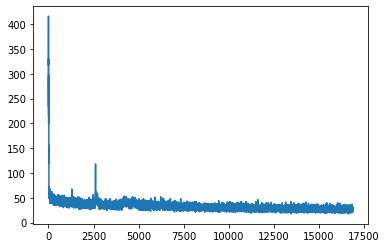

epoch: 10 	 step:0 	 loss: 31.71
epoch: 10 	 step:100 	 loss: 25.89
epoch: 10 	 step:200 	 loss: 25.19
epoch: 10 	 step:300 	 loss: 26.41
epoch: 10 	 step:400 	 loss: 23.03
epoch: 10 	 step:500 	 loss: 27.91
epoch: 10 	 step:600 	 loss: 27.28
epoch: 10 	 step:700 	 loss: 23.32
epoch: 10 	 step:800 	 loss: 29.74
epoch: 10 	 step:900 	 loss: 27.58
epoch: 10 	 step:1000 	 loss: 27.06
epoch: 10 	 step:1100 	 loss: 29.96
epoch: 10 	 step:1200 	 loss: 22.71
epoch: 10 	 step:1300 	 loss: 26.65
epoch: 10 	 step:1400 	 loss: 33.87
epoch: 10 	 step:1500 	 loss: 27.3
epoch: 10 	 step:1600 	 loss: 19.5
epoch: 10 	 step:1700 	 loss: 28.15
epoch: 10 	 step:1800 	 loss: 22.54


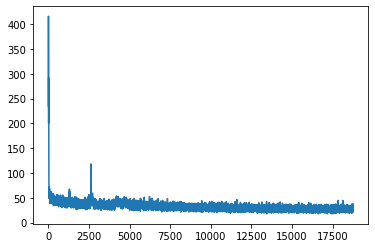

epoch: 11 	 step:0 	 loss: 25.75
epoch: 11 	 step:100 	 loss: 21.14
epoch: 11 	 step:200 	 loss: 29.23
epoch: 11 	 step:300 	 loss: 26.88
epoch: 11 	 step:400 	 loss: 29.73
epoch: 11 	 step:500 	 loss: 23.87
epoch: 11 	 step:600 	 loss: 28.0
epoch: 11 	 step:700 	 loss: 29.03
epoch: 11 	 step:800 	 loss: 26.81
epoch: 11 	 step:900 	 loss: 27.93
epoch: 11 	 step:1000 	 loss: 19.74
epoch: 11 	 step:1100 	 loss: 20.6
epoch: 11 	 step:1200 	 loss: 25.64
epoch: 11 	 step:1300 	 loss: 21.54
epoch: 11 	 step:1400 	 loss: 25.12
epoch: 11 	 step:1500 	 loss: 19.61
epoch: 11 	 step:1600 	 loss: 26.86
epoch: 11 	 step:1700 	 loss: 30.24
epoch: 11 	 step:1800 	 loss: 29.39


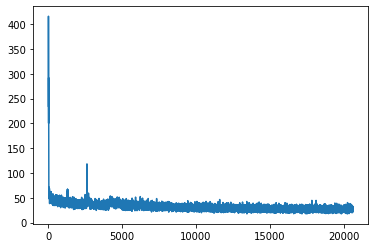

epoch: 12 	 step:0 	 loss: 25.44
epoch: 12 	 step:100 	 loss: 23.04
epoch: 12 	 step:200 	 loss: 26.11
epoch: 12 	 step:300 	 loss: 25.16
epoch: 12 	 step:400 	 loss: 27.2
epoch: 12 	 step:500 	 loss: 23.03
epoch: 12 	 step:600 	 loss: 27.86
epoch: 12 	 step:700 	 loss: 22.4
epoch: 12 	 step:800 	 loss: 26.32
epoch: 12 	 step:900 	 loss: 23.88
epoch: 12 	 step:1000 	 loss: 24.93
epoch: 12 	 step:1100 	 loss: 25.13
epoch: 12 	 step:1200 	 loss: 28.55
epoch: 12 	 step:1300 	 loss: 23.62
epoch: 12 	 step:1400 	 loss: 25.92
epoch: 12 	 step:1500 	 loss: 22.72
epoch: 12 	 step:1600 	 loss: 25.71
epoch: 12 	 step:1700 	 loss: 27.24
epoch: 12 	 step:1800 	 loss: 31.46


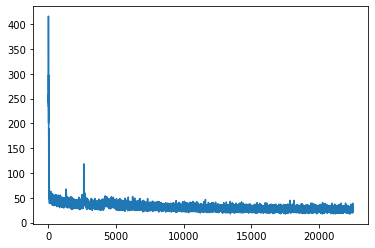

epoch: 13 	 step:0 	 loss: 19.74
epoch: 13 	 step:100 	 loss: 24.9
epoch: 13 	 step:200 	 loss: 21.82
epoch: 13 	 step:300 	 loss: 25.16
epoch: 13 	 step:400 	 loss: 26.98
epoch: 13 	 step:500 	 loss: 27.49
epoch: 13 	 step:600 	 loss: 24.09
epoch: 13 	 step:700 	 loss: 23.15
epoch: 13 	 step:800 	 loss: 32.66
epoch: 13 	 step:900 	 loss: 21.91
epoch: 13 	 step:1000 	 loss: 26.48
epoch: 13 	 step:1100 	 loss: 22.83
epoch: 13 	 step:1200 	 loss: 25.73
epoch: 13 	 step:1300 	 loss: 23.28
epoch: 13 	 step:1400 	 loss: 22.76
epoch: 13 	 step:1500 	 loss: 27.74
epoch: 13 	 step:1600 	 loss: 25.94
epoch: 13 	 step:1700 	 loss: 32.09
epoch: 13 	 step:1800 	 loss: 22.2


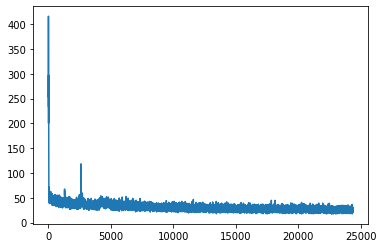

epoch: 14 	 step:0 	 loss: 21.91
epoch: 14 	 step:100 	 loss: 27.42
epoch: 14 	 step:200 	 loss: 24.33
epoch: 14 	 step:300 	 loss: 25.96
epoch: 14 	 step:400 	 loss: 22.07
epoch: 14 	 step:500 	 loss: 22.49
epoch: 14 	 step:600 	 loss: 26.42
epoch: 14 	 step:700 	 loss: 22.07
epoch: 14 	 step:800 	 loss: 24.01
epoch: 14 	 step:900 	 loss: 24.02
epoch: 14 	 step:1000 	 loss: 23.02
epoch: 14 	 step:1100 	 loss: 25.27
epoch: 14 	 step:1200 	 loss: 26.61
epoch: 14 	 step:1300 	 loss: 26.38
epoch: 14 	 step:1400 	 loss: 24.1
epoch: 14 	 step:1500 	 loss: 22.92
epoch: 14 	 step:1600 	 loss: 22.27
epoch: 14 	 step:1700 	 loss: 20.92
epoch: 14 	 step:1800 	 loss: 24.68


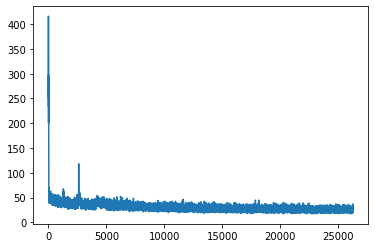

epoch: 15 	 step:0 	 loss: 25.1
epoch: 15 	 step:100 	 loss: 22.6
epoch: 15 	 step:200 	 loss: 24.28
epoch: 15 	 step:300 	 loss: 23.35
epoch: 15 	 step:400 	 loss: 25.21
epoch: 15 	 step:500 	 loss: 20.67
epoch: 15 	 step:600 	 loss: 25.64
epoch: 15 	 step:700 	 loss: 24.13
epoch: 15 	 step:800 	 loss: 21.72
epoch: 15 	 step:900 	 loss: 26.3
epoch: 15 	 step:1000 	 loss: 24.53
epoch: 15 	 step:1100 	 loss: 31.78
epoch: 15 	 step:1200 	 loss: 22.23
epoch: 15 	 step:1300 	 loss: 25.22
epoch: 15 	 step:1400 	 loss: 27.44
epoch: 15 	 step:1500 	 loss: 22.87
epoch: 15 	 step:1600 	 loss: 25.67
epoch: 15 	 step:1700 	 loss: 25.46
epoch: 15 	 step:1800 	 loss: 23.9


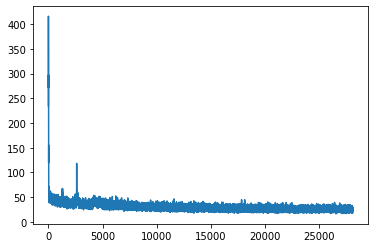

epoch: 16 	 step:0 	 loss: 22.58
epoch: 16 	 step:100 	 loss: 25.28
epoch: 16 	 step:200 	 loss: 19.74
epoch: 16 	 step:300 	 loss: 33.61
epoch: 16 	 step:400 	 loss: 18.59
epoch: 16 	 step:500 	 loss: 27.13
epoch: 16 	 step:600 	 loss: 23.76
epoch: 16 	 step:700 	 loss: 25.85
epoch: 16 	 step:800 	 loss: 29.07
epoch: 16 	 step:900 	 loss: 23.61
epoch: 16 	 step:1000 	 loss: 28.34
epoch: 16 	 step:1100 	 loss: 21.42
epoch: 16 	 step:1200 	 loss: 30.2
epoch: 16 	 step:1300 	 loss: 21.8
epoch: 16 	 step:1400 	 loss: 24.13
epoch: 16 	 step:1500 	 loss: 25.71
epoch: 16 	 step:1600 	 loss: 21.64
epoch: 16 	 step:1700 	 loss: 26.16
epoch: 16 	 step:1800 	 loss: 25.14


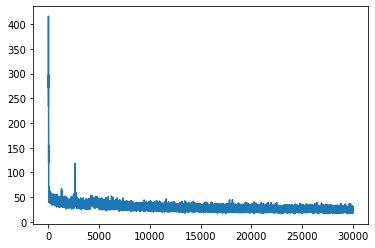

epoch: 17 	 step:0 	 loss: 25.93
epoch: 17 	 step:100 	 loss: 22.64
epoch: 17 	 step:200 	 loss: 21.39
epoch: 17 	 step:300 	 loss: 21.1
epoch: 17 	 step:400 	 loss: 20.73
epoch: 17 	 step:500 	 loss: 26.77
epoch: 17 	 step:600 	 loss: 27.55
epoch: 17 	 step:700 	 loss: 27.46
epoch: 17 	 step:800 	 loss: 21.5
epoch: 17 	 step:900 	 loss: 24.14
epoch: 17 	 step:1000 	 loss: 24.34
epoch: 17 	 step:1100 	 loss: 23.78
epoch: 17 	 step:1200 	 loss: 32.53
epoch: 17 	 step:1300 	 loss: 21.79
epoch: 17 	 step:1400 	 loss: 19.07
epoch: 17 	 step:1500 	 loss: 30.07
epoch: 17 	 step:1600 	 loss: 22.99
epoch: 17 	 step:1700 	 loss: 29.41
epoch: 17 	 step:1800 	 loss: 22.95


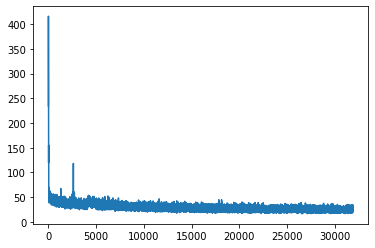

epoch: 18 	 step:0 	 loss: 26.48
epoch: 18 	 step:100 	 loss: 24.32
epoch: 18 	 step:200 	 loss: 24.68
epoch: 18 	 step:300 	 loss: 27.26
epoch: 18 	 step:400 	 loss: 17.5
epoch: 18 	 step:500 	 loss: 20.91
epoch: 18 	 step:600 	 loss: 29.31
epoch: 18 	 step:700 	 loss: 23.74
epoch: 18 	 step:800 	 loss: 23.66
epoch: 18 	 step:900 	 loss: 20.47
epoch: 18 	 step:1000 	 loss: 25.42
epoch: 18 	 step:1100 	 loss: 22.59
epoch: 18 	 step:1200 	 loss: 31.67
epoch: 18 	 step:1300 	 loss: 24.32
epoch: 18 	 step:1400 	 loss: 24.45
epoch: 18 	 step:1500 	 loss: 22.16
epoch: 18 	 step:1600 	 loss: 24.43
epoch: 18 	 step:1700 	 loss: 33.62
epoch: 18 	 step:1800 	 loss: 24.52


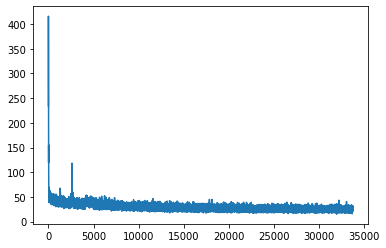

epoch: 19 	 step:0 	 loss: 26.34
epoch: 19 	 step:100 	 loss: 23.2
epoch: 19 	 step:200 	 loss: 24.91
epoch: 19 	 step:300 	 loss: 20.79
epoch: 19 	 step:400 	 loss: 26.41
epoch: 19 	 step:500 	 loss: 20.88
epoch: 19 	 step:600 	 loss: 26.28
epoch: 19 	 step:700 	 loss: 32.83
epoch: 19 	 step:800 	 loss: 25.82
epoch: 19 	 step:900 	 loss: 26.37
epoch: 19 	 step:1000 	 loss: 19.33
epoch: 19 	 step:1100 	 loss: 24.01
epoch: 19 	 step:1200 	 loss: 24.28
epoch: 19 	 step:1300 	 loss: 21.16
epoch: 19 	 step:1400 	 loss: 27.23
epoch: 19 	 step:1500 	 loss: 23.66
epoch: 19 	 step:1600 	 loss: 23.29
epoch: 19 	 step:1700 	 loss: 23.51
epoch: 19 	 step:1800 	 loss: 21.37


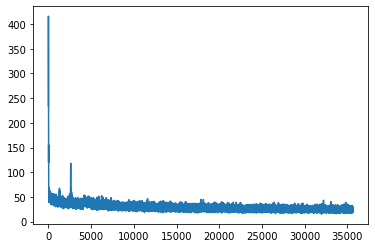

epoch: 20 	 step:0 	 loss: 21.46
epoch: 20 	 step:100 	 loss: 27.56
epoch: 20 	 step:200 	 loss: 24.21
epoch: 20 	 step:300 	 loss: 20.63
epoch: 20 	 step:400 	 loss: 22.39
epoch: 20 	 step:500 	 loss: 24.31
epoch: 20 	 step:600 	 loss: 22.54
epoch: 20 	 step:700 	 loss: 21.73
epoch: 20 	 step:800 	 loss: 19.78
epoch: 20 	 step:900 	 loss: 22.93
epoch: 20 	 step:1000 	 loss: 21.09
epoch: 20 	 step:1100 	 loss: 22.27
epoch: 20 	 step:1200 	 loss: 25.48
epoch: 20 	 step:1300 	 loss: 24.42
epoch: 20 	 step:1400 	 loss: 26.18
epoch: 20 	 step:1500 	 loss: 22.05
epoch: 20 	 step:1600 	 loss: 21.48
epoch: 20 	 step:1700 	 loss: 21.57
epoch: 20 	 step:1800 	 loss: 29.23


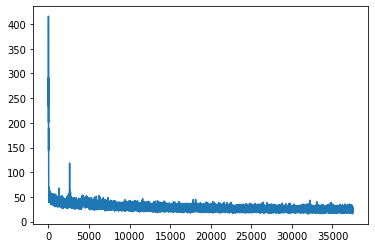

epoch: 21 	 step:0 	 loss: 18.02
epoch: 21 	 step:100 	 loss: 28.25
epoch: 21 	 step:200 	 loss: 20.0
epoch: 21 	 step:300 	 loss: 19.14
epoch: 21 	 step:400 	 loss: 22.09
epoch: 21 	 step:500 	 loss: 25.12
epoch: 21 	 step:600 	 loss: 26.77
epoch: 21 	 step:700 	 loss: 24.82
epoch: 21 	 step:800 	 loss: 25.23
epoch: 21 	 step:900 	 loss: 32.69
epoch: 21 	 step:1000 	 loss: 22.91
epoch: 21 	 step:1100 	 loss: 26.3
epoch: 21 	 step:1200 	 loss: 24.68
epoch: 21 	 step:1300 	 loss: 20.93
epoch: 21 	 step:1400 	 loss: 24.67
epoch: 21 	 step:1500 	 loss: 25.26
epoch: 21 	 step:1600 	 loss: 27.3
epoch: 21 	 step:1700 	 loss: 21.01
epoch: 21 	 step:1800 	 loss: 18.61


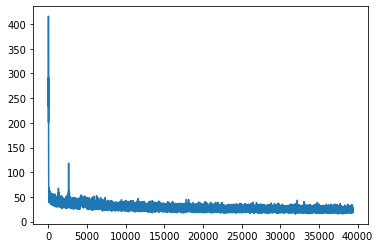

epoch: 22 	 step:0 	 loss: 28.8
epoch: 22 	 step:100 	 loss: 21.87
epoch: 22 	 step:200 	 loss: 28.11
epoch: 22 	 step:300 	 loss: 25.65
epoch: 22 	 step:400 	 loss: 21.67
epoch: 22 	 step:500 	 loss: 23.14
epoch: 22 	 step:600 	 loss: 30.67
epoch: 22 	 step:700 	 loss: 24.18
epoch: 22 	 step:800 	 loss: 20.53
epoch: 22 	 step:900 	 loss: 22.92
epoch: 22 	 step:1000 	 loss: 21.92
epoch: 22 	 step:1100 	 loss: 25.05
epoch: 22 	 step:1200 	 loss: 20.15
epoch: 22 	 step:1300 	 loss: 23.53
epoch: 22 	 step:1400 	 loss: 20.57
epoch: 22 	 step:1500 	 loss: 25.73
epoch: 22 	 step:1600 	 loss: 23.18
epoch: 22 	 step:1700 	 loss: 20.76
epoch: 22 	 step:1800 	 loss: 24.99


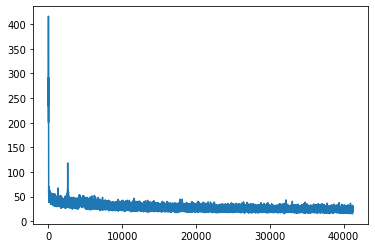

epoch: 23 	 step:0 	 loss: 26.92
epoch: 23 	 step:100 	 loss: 24.09
epoch: 23 	 step:200 	 loss: 29.76
epoch: 23 	 step:300 	 loss: 28.01
epoch: 23 	 step:400 	 loss: 22.73
epoch: 23 	 step:500 	 loss: 27.44
epoch: 23 	 step:600 	 loss: 19.27
epoch: 23 	 step:700 	 loss: 23.3
epoch: 23 	 step:800 	 loss: 21.9
epoch: 23 	 step:900 	 loss: 23.95
epoch: 23 	 step:1000 	 loss: 25.79
epoch: 23 	 step:1100 	 loss: 23.35
epoch: 23 	 step:1200 	 loss: 20.06
epoch: 23 	 step:1300 	 loss: 20.93
epoch: 23 	 step:1400 	 loss: 23.66
epoch: 23 	 step:1500 	 loss: 19.23
epoch: 23 	 step:1600 	 loss: 24.87
epoch: 23 	 step:1700 	 loss: 19.75
epoch: 23 	 step:1800 	 loss: 27.65


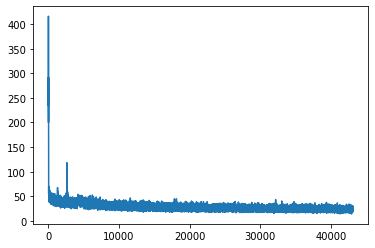

epoch: 24 	 step:0 	 loss: 17.82
epoch: 24 	 step:100 	 loss: 21.81
epoch: 24 	 step:200 	 loss: 19.99
epoch: 24 	 step:300 	 loss: 26.19
epoch: 24 	 step:400 	 loss: 22.21
epoch: 24 	 step:500 	 loss: 27.36
epoch: 24 	 step:600 	 loss: 22.27
epoch: 24 	 step:700 	 loss: 19.8
epoch: 24 	 step:800 	 loss: 19.06
epoch: 24 	 step:900 	 loss: 22.36
epoch: 24 	 step:1000 	 loss: 23.7
epoch: 24 	 step:1100 	 loss: 21.83
epoch: 24 	 step:1200 	 loss: 18.37
epoch: 24 	 step:1300 	 loss: 21.68
epoch: 24 	 step:1400 	 loss: 18.85
epoch: 24 	 step:1500 	 loss: 24.91
epoch: 24 	 step:1600 	 loss: 23.15
epoch: 24 	 step:1700 	 loss: 22.57
epoch: 24 	 step:1800 	 loss: 21.6


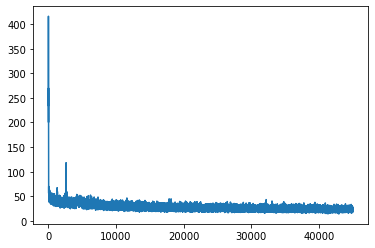

epoch: 25 	 step:0 	 loss: 18.84
epoch: 25 	 step:100 	 loss: 20.01
epoch: 25 	 step:200 	 loss: 21.57
epoch: 25 	 step:300 	 loss: 19.39
epoch: 25 	 step:400 	 loss: 24.17
epoch: 25 	 step:500 	 loss: 21.84
epoch: 25 	 step:600 	 loss: 20.38
epoch: 25 	 step:700 	 loss: 30.74
epoch: 25 	 step:800 	 loss: 21.87
epoch: 25 	 step:900 	 loss: 19.99
epoch: 25 	 step:1000 	 loss: 21.57
epoch: 25 	 step:1100 	 loss: 27.89
epoch: 25 	 step:1200 	 loss: 19.65
epoch: 25 	 step:1300 	 loss: 22.41
epoch: 25 	 step:1400 	 loss: 24.67
epoch: 25 	 step:1500 	 loss: 23.01
epoch: 25 	 step:1600 	 loss: 20.43
epoch: 25 	 step:1700 	 loss: 26.08
epoch: 25 	 step:1800 	 loss: 21.89


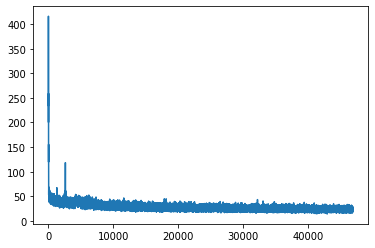

epoch: 26 	 step:0 	 loss: 23.48
epoch: 26 	 step:100 	 loss: 24.89
epoch: 26 	 step:200 	 loss: 20.44
epoch: 26 	 step:300 	 loss: 21.43
epoch: 26 	 step:400 	 loss: 25.6
epoch: 26 	 step:500 	 loss: 25.6
epoch: 26 	 step:600 	 loss: 23.99
epoch: 26 	 step:700 	 loss: 24.72
epoch: 26 	 step:800 	 loss: 25.53
epoch: 26 	 step:900 	 loss: 24.34
epoch: 26 	 step:1000 	 loss: 20.0
epoch: 26 	 step:1100 	 loss: 22.46
epoch: 26 	 step:1200 	 loss: 24.32
epoch: 26 	 step:1300 	 loss: 25.74
epoch: 26 	 step:1400 	 loss: 28.69
epoch: 26 	 step:1500 	 loss: 22.17
epoch: 26 	 step:1600 	 loss: 21.79
epoch: 26 	 step:1700 	 loss: 21.45
epoch: 26 	 step:1800 	 loss: 20.55


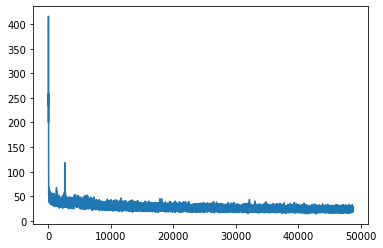

epoch: 27 	 step:0 	 loss: 26.6
epoch: 27 	 step:100 	 loss: 25.12
epoch: 27 	 step:200 	 loss: 21.72
epoch: 27 	 step:300 	 loss: 21.99
epoch: 27 	 step:400 	 loss: 21.92
epoch: 27 	 step:500 	 loss: 23.02
epoch: 27 	 step:600 	 loss: 21.98
epoch: 27 	 step:700 	 loss: 21.5
epoch: 27 	 step:800 	 loss: 22.83
epoch: 27 	 step:900 	 loss: 20.26
epoch: 27 	 step:1000 	 loss: 23.87
epoch: 27 	 step:1100 	 loss: 19.66
epoch: 27 	 step:1200 	 loss: 25.14
epoch: 27 	 step:1300 	 loss: 19.27
epoch: 27 	 step:1400 	 loss: 23.92
epoch: 27 	 step:1500 	 loss: 23.3
epoch: 27 	 step:1600 	 loss: 18.77
epoch: 27 	 step:1700 	 loss: 22.83
epoch: 27 	 step:1800 	 loss: 20.72


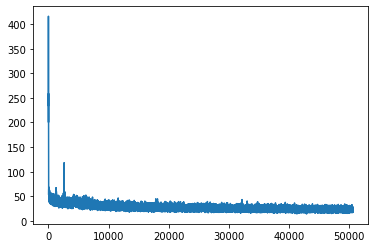

epoch: 28 	 step:0 	 loss: 24.63
epoch: 28 	 step:100 	 loss: 24.44
epoch: 28 	 step:200 	 loss: 17.86
epoch: 28 	 step:300 	 loss: 27.12
epoch: 28 	 step:400 	 loss: 21.59
epoch: 28 	 step:500 	 loss: 21.56
epoch: 28 	 step:600 	 loss: 20.99
epoch: 28 	 step:700 	 loss: 23.05
epoch: 28 	 step:800 	 loss: 21.37
epoch: 28 	 step:900 	 loss: 31.89
epoch: 28 	 step:1000 	 loss: 20.55
epoch: 28 	 step:1100 	 loss: 16.13
epoch: 28 	 step:1200 	 loss: 20.0
epoch: 28 	 step:1300 	 loss: 25.28
epoch: 28 	 step:1400 	 loss: 19.66
epoch: 28 	 step:1500 	 loss: 22.24
epoch: 28 	 step:1600 	 loss: 21.09
epoch: 28 	 step:1700 	 loss: 24.44
epoch: 28 	 step:1800 	 loss: 25.87


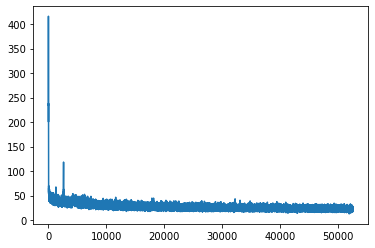

epoch: 29 	 step:0 	 loss: 22.54
epoch: 29 	 step:100 	 loss: 18.36
epoch: 29 	 step:200 	 loss: 26.92
epoch: 29 	 step:300 	 loss: 21.21
epoch: 29 	 step:400 	 loss: 22.42
epoch: 29 	 step:500 	 loss: 24.92
epoch: 29 	 step:600 	 loss: 23.52
epoch: 29 	 step:700 	 loss: 23.71
epoch: 29 	 step:800 	 loss: 16.79
epoch: 29 	 step:900 	 loss: 21.01
epoch: 29 	 step:1000 	 loss: 22.48
epoch: 29 	 step:1100 	 loss: 28.56
epoch: 29 	 step:1200 	 loss: 17.75
epoch: 29 	 step:1300 	 loss: 22.61
epoch: 29 	 step:1400 	 loss: 20.96
epoch: 29 	 step:1500 	 loss: 20.09
epoch: 29 	 step:1600 	 loss: 25.98
epoch: 29 	 step:1700 	 loss: 22.78
epoch: 29 	 step:1800 	 loss: 17.86


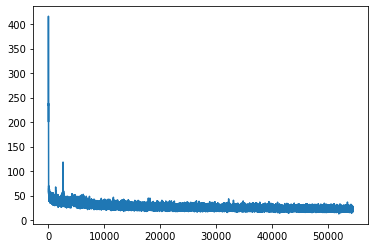

epoch: 30 	 step:0 	 loss: 22.93
epoch: 30 	 step:100 	 loss: 21.48
epoch: 30 	 step:200 	 loss: 16.96
epoch: 30 	 step:300 	 loss: 26.64
epoch: 30 	 step:400 	 loss: 20.12
epoch: 30 	 step:500 	 loss: 26.26
epoch: 30 	 step:600 	 loss: 24.32
epoch: 30 	 step:700 	 loss: 26.15
epoch: 30 	 step:800 	 loss: 21.35
epoch: 30 	 step:900 	 loss: 21.86
epoch: 30 	 step:1000 	 loss: 25.62
epoch: 30 	 step:1100 	 loss: 24.39
epoch: 30 	 step:1200 	 loss: 19.89
epoch: 30 	 step:1300 	 loss: 26.03
epoch: 30 	 step:1400 	 loss: 28.11
epoch: 30 	 step:1500 	 loss: 30.53
epoch: 30 	 step:1600 	 loss: 22.06
epoch: 30 	 step:1700 	 loss: 24.39
epoch: 30 	 step:1800 	 loss: 17.72


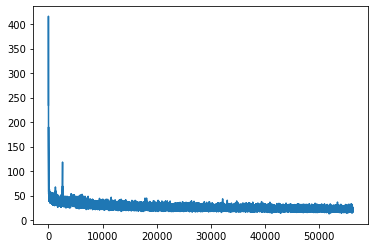

epoch: 31 	 step:0 	 loss: 21.99
epoch: 31 	 step:100 	 loss: 20.54
epoch: 31 	 step:200 	 loss: 23.5
epoch: 31 	 step:300 	 loss: 18.92
epoch: 31 	 step:400 	 loss: 23.69
epoch: 31 	 step:500 	 loss: 21.96
epoch: 31 	 step:600 	 loss: 27.33
epoch: 31 	 step:700 	 loss: 20.22
epoch: 31 	 step:800 	 loss: 20.13
epoch: 31 	 step:900 	 loss: 19.45
epoch: 31 	 step:1000 	 loss: 22.48
epoch: 31 	 step:1100 	 loss: 19.19
epoch: 31 	 step:1200 	 loss: 20.57
epoch: 31 	 step:1300 	 loss: 20.01
epoch: 31 	 step:1400 	 loss: 24.28
epoch: 31 	 step:1500 	 loss: 20.35
epoch: 31 	 step:1600 	 loss: 23.06
epoch: 31 	 step:1700 	 loss: 26.15
epoch: 31 	 step:1800 	 loss: 21.13


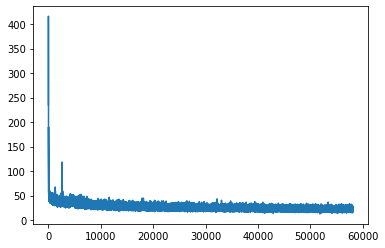

epoch: 32 	 step:0 	 loss: 22.69
epoch: 32 	 step:100 	 loss: 18.58
epoch: 32 	 step:200 	 loss: 21.56
epoch: 32 	 step:300 	 loss: 24.19
epoch: 32 	 step:400 	 loss: 20.74
epoch: 32 	 step:500 	 loss: 20.58
epoch: 32 	 step:600 	 loss: 19.37
epoch: 32 	 step:700 	 loss: 20.63
epoch: 32 	 step:800 	 loss: 27.77
epoch: 32 	 step:900 	 loss: 22.73
epoch: 32 	 step:1000 	 loss: 26.81
epoch: 32 	 step:1100 	 loss: 26.58
epoch: 32 	 step:1200 	 loss: 19.58
epoch: 32 	 step:1300 	 loss: 20.1
epoch: 32 	 step:1400 	 loss: 21.02
epoch: 32 	 step:1500 	 loss: 19.02
epoch: 32 	 step:1600 	 loss: 17.54
epoch: 32 	 step:1700 	 loss: 23.92
epoch: 32 	 step:1800 	 loss: 27.25


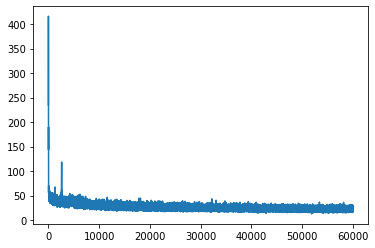

epoch: 33 	 step:0 	 loss: 24.81
epoch: 33 	 step:100 	 loss: 22.19
epoch: 33 	 step:200 	 loss: 23.08
epoch: 33 	 step:300 	 loss: 19.68
epoch: 33 	 step:400 	 loss: 22.64
epoch: 33 	 step:500 	 loss: 20.55
epoch: 33 	 step:600 	 loss: 20.96
epoch: 33 	 step:700 	 loss: 25.29
epoch: 33 	 step:800 	 loss: 22.36
epoch: 33 	 step:900 	 loss: 26.39
epoch: 33 	 step:1000 	 loss: 21.54
epoch: 33 	 step:1100 	 loss: 23.5
epoch: 33 	 step:1200 	 loss: 21.72
epoch: 33 	 step:1300 	 loss: 21.34
epoch: 33 	 step:1400 	 loss: 18.53
epoch: 33 	 step:1500 	 loss: 25.02
epoch: 33 	 step:1600 	 loss: 23.25
epoch: 33 	 step:1700 	 loss: 16.92
epoch: 33 	 step:1800 	 loss: 28.97


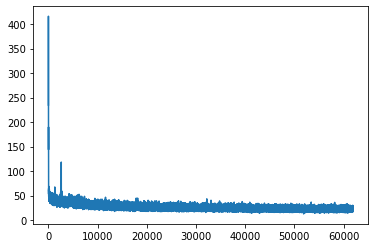

epoch: 34 	 step:0 	 loss: 19.47
epoch: 34 	 step:100 	 loss: 22.9
epoch: 34 	 step:200 	 loss: 16.86
epoch: 34 	 step:300 	 loss: 22.47
epoch: 34 	 step:400 	 loss: 21.57
epoch: 34 	 step:500 	 loss: 21.38
epoch: 34 	 step:600 	 loss: 21.3
epoch: 34 	 step:700 	 loss: 25.17
epoch: 34 	 step:800 	 loss: 20.17
epoch: 34 	 step:900 	 loss: 21.93
epoch: 34 	 step:1000 	 loss: 22.25
epoch: 34 	 step:1100 	 loss: 19.86
epoch: 34 	 step:1200 	 loss: 22.9
epoch: 34 	 step:1300 	 loss: 22.06
epoch: 34 	 step:1400 	 loss: 25.24
epoch: 34 	 step:1500 	 loss: 22.09
epoch: 34 	 step:1600 	 loss: 25.72
epoch: 34 	 step:1700 	 loss: 16.4
epoch: 34 	 step:1800 	 loss: 21.04


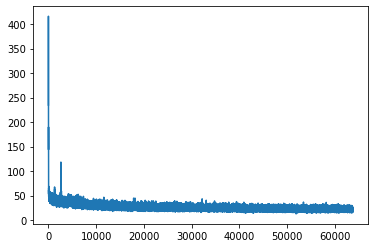

epoch: 35 	 step:0 	 loss: 17.12
epoch: 35 	 step:100 	 loss: 19.48
epoch: 35 	 step:200 	 loss: 22.6
epoch: 35 	 step:300 	 loss: 21.26
epoch: 35 	 step:400 	 loss: 23.33
epoch: 35 	 step:500 	 loss: 19.13
epoch: 35 	 step:600 	 loss: 17.94
epoch: 35 	 step:700 	 loss: 26.84
epoch: 35 	 step:800 	 loss: 19.58
epoch: 35 	 step:900 	 loss: 18.41
epoch: 35 	 step:1000 	 loss: 23.64
epoch: 35 	 step:1100 	 loss: 22.23
epoch: 35 	 step:1200 	 loss: 20.65
epoch: 35 	 step:1300 	 loss: 17.93
epoch: 35 	 step:1400 	 loss: 24.35
epoch: 35 	 step:1500 	 loss: 21.95
epoch: 35 	 step:1600 	 loss: 19.68
epoch: 35 	 step:1700 	 loss: 22.25
epoch: 35 	 step:1800 	 loss: 25.43


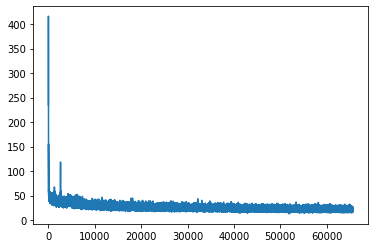

epoch: 36 	 step:0 	 loss: 23.87
epoch: 36 	 step:100 	 loss: 25.03
epoch: 36 	 step:200 	 loss: 23.74
epoch: 36 	 step:300 	 loss: 20.47
epoch: 36 	 step:400 	 loss: 22.77
epoch: 36 	 step:500 	 loss: 20.58
epoch: 36 	 step:600 	 loss: 21.44
epoch: 36 	 step:700 	 loss: 24.55
epoch: 36 	 step:800 	 loss: 18.42
epoch: 36 	 step:900 	 loss: 20.76
epoch: 36 	 step:1000 	 loss: 23.13
epoch: 36 	 step:1100 	 loss: 18.26
epoch: 36 	 step:1200 	 loss: 20.75
epoch: 36 	 step:1300 	 loss: 15.93
epoch: 36 	 step:1400 	 loss: 18.93
epoch: 36 	 step:1500 	 loss: 19.54
epoch: 36 	 step:1600 	 loss: 21.9
epoch: 36 	 step:1700 	 loss: 17.76
epoch: 36 	 step:1800 	 loss: 24.14


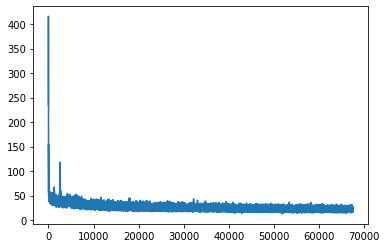

epoch: 37 	 step:0 	 loss: 19.92
epoch: 37 	 step:100 	 loss: 22.67
epoch: 37 	 step:200 	 loss: 24.4
epoch: 37 	 step:300 	 loss: 22.05
epoch: 37 	 step:400 	 loss: 21.71
epoch: 37 	 step:500 	 loss: 22.41
epoch: 37 	 step:600 	 loss: 22.78
epoch: 37 	 step:700 	 loss: 17.8
epoch: 37 	 step:800 	 loss: 22.44
epoch: 37 	 step:900 	 loss: 22.16
epoch: 37 	 step:1000 	 loss: 16.46
epoch: 37 	 step:1100 	 loss: 19.62
epoch: 37 	 step:1200 	 loss: 21.4
epoch: 37 	 step:1300 	 loss: 20.5
epoch: 37 	 step:1400 	 loss: 20.76
epoch: 37 	 step:1500 	 loss: 24.1
epoch: 37 	 step:1600 	 loss: 20.55
epoch: 37 	 step:1700 	 loss: 24.35
epoch: 37 	 step:1800 	 loss: 20.81


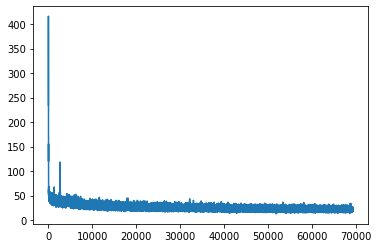

epoch: 38 	 step:0 	 loss: 22.4
epoch: 38 	 step:100 	 loss: 19.22
epoch: 38 	 step:200 	 loss: 22.0
epoch: 38 	 step:300 	 loss: 21.74
epoch: 38 	 step:400 	 loss: 19.6
epoch: 38 	 step:500 	 loss: 22.31
epoch: 38 	 step:600 	 loss: 18.11
epoch: 38 	 step:700 	 loss: 23.6
epoch: 38 	 step:800 	 loss: 23.47
epoch: 38 	 step:900 	 loss: 20.06
epoch: 38 	 step:1000 	 loss: 18.66
epoch: 38 	 step:1100 	 loss: 25.71
epoch: 38 	 step:1200 	 loss: 21.47
epoch: 38 	 step:1300 	 loss: 24.13
epoch: 38 	 step:1400 	 loss: 22.31
epoch: 38 	 step:1500 	 loss: 24.54
epoch: 38 	 step:1600 	 loss: 19.85
epoch: 38 	 step:1700 	 loss: 19.92
epoch: 38 	 step:1800 	 loss: 23.17


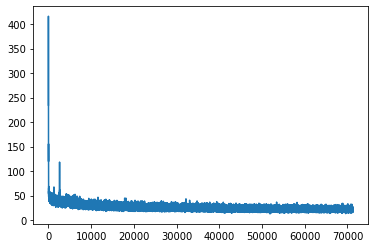

epoch: 39 	 step:0 	 loss: 19.84
epoch: 39 	 step:100 	 loss: 21.64
epoch: 39 	 step:200 	 loss: 23.04
epoch: 39 	 step:300 	 loss: 20.41
epoch: 39 	 step:400 	 loss: 21.99
epoch: 39 	 step:500 	 loss: 23.87
epoch: 39 	 step:600 	 loss: 20.57
epoch: 39 	 step:700 	 loss: 18.31
epoch: 39 	 step:800 	 loss: 21.61
epoch: 39 	 step:900 	 loss: 20.48
epoch: 39 	 step:1000 	 loss: 21.62
epoch: 39 	 step:1100 	 loss: 24.57
epoch: 39 	 step:1200 	 loss: 17.84
epoch: 39 	 step:1300 	 loss: 23.59
epoch: 39 	 step:1400 	 loss: 15.43
epoch: 39 	 step:1500 	 loss: 20.18
epoch: 39 	 step:1600 	 loss: 19.81
epoch: 39 	 step:1700 	 loss: 23.81
epoch: 39 	 step:1800 	 loss: 21.33


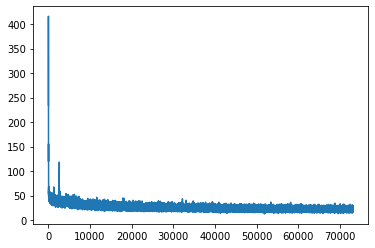

epoch: 40 	 step:0 	 loss: 16.38
epoch: 40 	 step:100 	 loss: 18.58
epoch: 40 	 step:200 	 loss: 21.32
epoch: 40 	 step:300 	 loss: 24.29
epoch: 40 	 step:400 	 loss: 20.22
epoch: 40 	 step:500 	 loss: 17.63
epoch: 40 	 step:600 	 loss: 26.37
epoch: 40 	 step:700 	 loss: 20.19
epoch: 40 	 step:800 	 loss: 21.86
epoch: 40 	 step:900 	 loss: 20.68
epoch: 40 	 step:1000 	 loss: 20.12
epoch: 40 	 step:1100 	 loss: 22.62
epoch: 40 	 step:1200 	 loss: 22.48
epoch: 40 	 step:1300 	 loss: 18.24
epoch: 40 	 step:1400 	 loss: 17.54
epoch: 40 	 step:1500 	 loss: 20.49
epoch: 40 	 step:1600 	 loss: 22.24
epoch: 40 	 step:1700 	 loss: 21.31
epoch: 40 	 step:1800 	 loss: 21.39


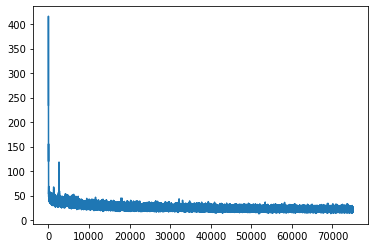

epoch: 41 	 step:0 	 loss: 21.86
epoch: 41 	 step:100 	 loss: 18.23
epoch: 41 	 step:200 	 loss: 21.44
epoch: 41 	 step:300 	 loss: 20.6
epoch: 41 	 step:400 	 loss: 24.67
epoch: 41 	 step:500 	 loss: 18.78
epoch: 41 	 step:600 	 loss: 20.76
epoch: 41 	 step:700 	 loss: 22.73
epoch: 41 	 step:800 	 loss: 22.06
epoch: 41 	 step:900 	 loss: 20.47
epoch: 41 	 step:1000 	 loss: 20.03
epoch: 41 	 step:1100 	 loss: 17.3
epoch: 41 	 step:1200 	 loss: 18.55
epoch: 41 	 step:1300 	 loss: 20.62
epoch: 41 	 step:1400 	 loss: 17.53
epoch: 41 	 step:1500 	 loss: 17.43
epoch: 41 	 step:1600 	 loss: 19.19
epoch: 41 	 step:1700 	 loss: 23.45
epoch: 41 	 step:1800 	 loss: 26.84


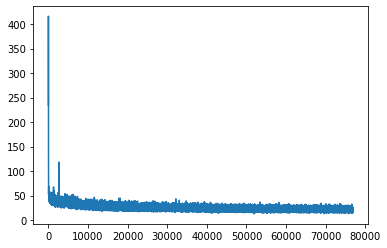

epoch: 42 	 step:0 	 loss: 22.65
epoch: 42 	 step:100 	 loss: 18.97
epoch: 42 	 step:200 	 loss: 23.03
epoch: 42 	 step:300 	 loss: 20.23
epoch: 42 	 step:400 	 loss: 17.28
epoch: 42 	 step:500 	 loss: 18.76
epoch: 42 	 step:600 	 loss: 18.21
epoch: 42 	 step:700 	 loss: 19.01
epoch: 42 	 step:800 	 loss: 27.14
epoch: 42 	 step:900 	 loss: 16.61
epoch: 42 	 step:1000 	 loss: 20.57
epoch: 42 	 step:1100 	 loss: 22.22
epoch: 42 	 step:1200 	 loss: 20.32
epoch: 42 	 step:1300 	 loss: 21.83
epoch: 42 	 step:1400 	 loss: 23.86
epoch: 42 	 step:1500 	 loss: 16.95
epoch: 42 	 step:1600 	 loss: 20.85
epoch: 42 	 step:1700 	 loss: 19.35
epoch: 42 	 step:1800 	 loss: 23.48


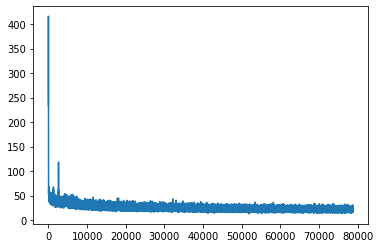

epoch: 43 	 step:0 	 loss: 24.49
epoch: 43 	 step:100 	 loss: 17.88
epoch: 43 	 step:200 	 loss: 23.53
epoch: 43 	 step:300 	 loss: 20.1
epoch: 43 	 step:400 	 loss: 21.63
epoch: 43 	 step:500 	 loss: 21.17
epoch: 43 	 step:600 	 loss: 21.07
epoch: 43 	 step:700 	 loss: 21.51
epoch: 43 	 step:800 	 loss: 19.53
epoch: 43 	 step:900 	 loss: 18.82
epoch: 43 	 step:1000 	 loss: 23.35
epoch: 43 	 step:1100 	 loss: 18.91
epoch: 43 	 step:1200 	 loss: 18.58
epoch: 43 	 step:1300 	 loss: 17.27
epoch: 43 	 step:1400 	 loss: 16.87
epoch: 43 	 step:1500 	 loss: 21.4
epoch: 43 	 step:1600 	 loss: 23.46
epoch: 43 	 step:1700 	 loss: 23.55
epoch: 43 	 step:1800 	 loss: 22.66


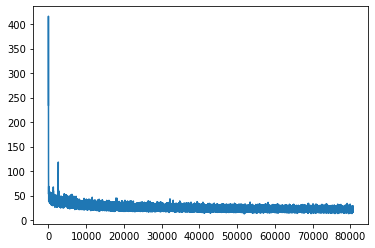

epoch: 44 	 step:0 	 loss: 19.1
epoch: 44 	 step:100 	 loss: 22.39
epoch: 44 	 step:200 	 loss: 20.71
epoch: 44 	 step:300 	 loss: 22.0
epoch: 44 	 step:400 	 loss: 24.41
epoch: 44 	 step:500 	 loss: 18.57
epoch: 44 	 step:600 	 loss: 21.59
epoch: 44 	 step:700 	 loss: 20.65
epoch: 44 	 step:800 	 loss: 19.1
epoch: 44 	 step:900 	 loss: 21.58
epoch: 44 	 step:1000 	 loss: 20.01
epoch: 44 	 step:1100 	 loss: 22.19
epoch: 44 	 step:1200 	 loss: 14.42
epoch: 44 	 step:1300 	 loss: 20.34
epoch: 44 	 step:1400 	 loss: 21.37
epoch: 44 	 step:1500 	 loss: 17.14
epoch: 44 	 step:1600 	 loss: 22.25
epoch: 44 	 step:1700 	 loss: 17.07
epoch: 44 	 step:1800 	 loss: 18.9


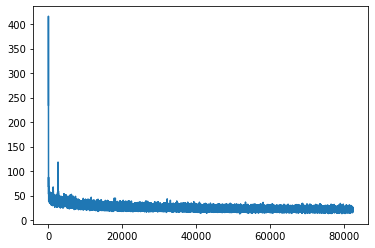

epoch: 45 	 step:0 	 loss: 22.63
epoch: 45 	 step:100 	 loss: 19.25
epoch: 45 	 step:200 	 loss: 28.06
epoch: 45 	 step:300 	 loss: 18.93
epoch: 45 	 step:400 	 loss: 20.09
epoch: 45 	 step:500 	 loss: 22.6
epoch: 45 	 step:600 	 loss: 19.3
epoch: 45 	 step:700 	 loss: 22.23
epoch: 45 	 step:800 	 loss: 19.08
epoch: 45 	 step:900 	 loss: 22.36
epoch: 45 	 step:1000 	 loss: 16.1
epoch: 45 	 step:1100 	 loss: 19.98
epoch: 45 	 step:1200 	 loss: 23.28
epoch: 45 	 step:1300 	 loss: 24.01
epoch: 45 	 step:1400 	 loss: 16.12
epoch: 45 	 step:1500 	 loss: 20.28
epoch: 45 	 step:1600 	 loss: 21.21
epoch: 45 	 step:1700 	 loss: 17.72
epoch: 45 	 step:1800 	 loss: 20.44


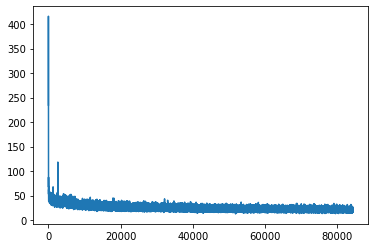

epoch: 46 	 step:0 	 loss: 17.84
epoch: 46 	 step:100 	 loss: 22.9
epoch: 46 	 step:200 	 loss: 18.63
epoch: 46 	 step:300 	 loss: 21.81
epoch: 46 	 step:400 	 loss: 18.18
epoch: 46 	 step:500 	 loss: 21.65
epoch: 46 	 step:600 	 loss: 14.23
epoch: 46 	 step:700 	 loss: 17.09
epoch: 46 	 step:800 	 loss: 28.83
epoch: 46 	 step:900 	 loss: 23.78
epoch: 46 	 step:1000 	 loss: 19.55
epoch: 46 	 step:1100 	 loss: 20.53
epoch: 46 	 step:1200 	 loss: 19.8
epoch: 46 	 step:1300 	 loss: 21.98
epoch: 46 	 step:1400 	 loss: 20.8
epoch: 46 	 step:1500 	 loss: 19.52
epoch: 46 	 step:1600 	 loss: 19.04
epoch: 46 	 step:1700 	 loss: 23.4
epoch: 46 	 step:1800 	 loss: 17.79


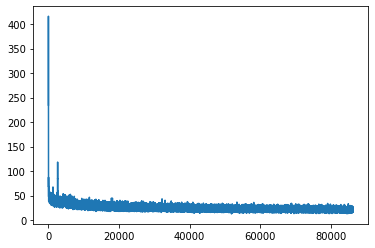

epoch: 47 	 step:0 	 loss: 20.3
epoch: 47 	 step:100 	 loss: 19.3
epoch: 47 	 step:200 	 loss: 18.16
epoch: 47 	 step:300 	 loss: 19.48
epoch: 47 	 step:400 	 loss: 23.39
epoch: 47 	 step:500 	 loss: 22.52
epoch: 47 	 step:600 	 loss: 21.94
epoch: 47 	 step:700 	 loss: 22.97
epoch: 47 	 step:800 	 loss: 22.91
epoch: 47 	 step:900 	 loss: 22.44
epoch: 47 	 step:1000 	 loss: 21.45
epoch: 47 	 step:1100 	 loss: 22.28
epoch: 47 	 step:1200 	 loss: 17.52
epoch: 47 	 step:1300 	 loss: 23.16
epoch: 47 	 step:1400 	 loss: 21.16
epoch: 47 	 step:1500 	 loss: 25.32
epoch: 47 	 step:1600 	 loss: 17.0
epoch: 47 	 step:1700 	 loss: 20.07
epoch: 47 	 step:1800 	 loss: 19.68


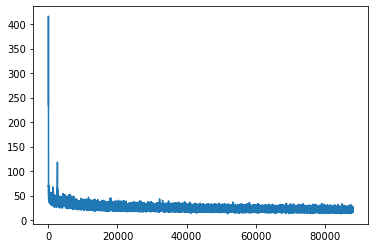

epoch: 48 	 step:0 	 loss: 18.06
epoch: 48 	 step:100 	 loss: 26.91
epoch: 48 	 step:200 	 loss: 17.12
epoch: 48 	 step:300 	 loss: 22.06
epoch: 48 	 step:400 	 loss: 18.06
epoch: 48 	 step:500 	 loss: 20.98
epoch: 48 	 step:600 	 loss: 18.5
epoch: 48 	 step:700 	 loss: 23.77
epoch: 48 	 step:800 	 loss: 16.25
epoch: 48 	 step:900 	 loss: 23.25
epoch: 48 	 step:1000 	 loss: 19.87
epoch: 48 	 step:1100 	 loss: 17.54
epoch: 48 	 step:1200 	 loss: 21.97
epoch: 48 	 step:1300 	 loss: 21.66
epoch: 48 	 step:1400 	 loss: 16.35
epoch: 48 	 step:1500 	 loss: 21.51
epoch: 48 	 step:1600 	 loss: 22.08
epoch: 48 	 step:1700 	 loss: 22.57
epoch: 48 	 step:1800 	 loss: 17.03


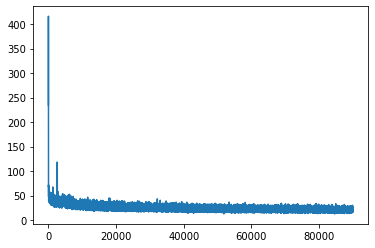

epoch: 49 	 step:0 	 loss: 22.0
epoch: 49 	 step:100 	 loss: 23.17
epoch: 49 	 step:200 	 loss: 17.83
epoch: 49 	 step:300 	 loss: 18.75
epoch: 49 	 step:400 	 loss: 18.57
epoch: 49 	 step:500 	 loss: 20.31
epoch: 49 	 step:600 	 loss: 20.07
epoch: 49 	 step:700 	 loss: 20.84
epoch: 49 	 step:800 	 loss: 15.56
epoch: 49 	 step:900 	 loss: 18.12
epoch: 49 	 step:1000 	 loss: 17.85
epoch: 49 	 step:1100 	 loss: 18.76
epoch: 49 	 step:1200 	 loss: 16.22
epoch: 49 	 step:1300 	 loss: 20.52
epoch: 49 	 step:1400 	 loss: 22.13
epoch: 49 	 step:1500 	 loss: 20.4
epoch: 49 	 step:1600 	 loss: 20.79
epoch: 49 	 step:1700 	 loss: 21.05
epoch: 49 	 step:1800 	 loss: 19.8


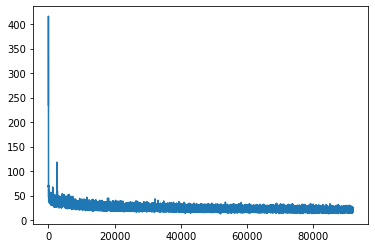

epoch: 50 	 step:0 	 loss: 23.96
epoch: 50 	 step:100 	 loss: 21.57
epoch: 50 	 step:200 	 loss: 23.55
epoch: 50 	 step:300 	 loss: 17.4
epoch: 50 	 step:400 	 loss: 20.74
epoch: 50 	 step:500 	 loss: 18.56
epoch: 50 	 step:600 	 loss: 21.59
epoch: 50 	 step:700 	 loss: 21.74
epoch: 50 	 step:800 	 loss: 20.61
epoch: 50 	 step:900 	 loss: 18.67
epoch: 50 	 step:1000 	 loss: 22.52
epoch: 50 	 step:1100 	 loss: 17.13
epoch: 50 	 step:1200 	 loss: 16.71
epoch: 50 	 step:1300 	 loss: 19.87
epoch: 50 	 step:1400 	 loss: 15.76
epoch: 50 	 step:1500 	 loss: 18.33
epoch: 50 	 step:1600 	 loss: 19.15
epoch: 50 	 step:1700 	 loss: 19.6
epoch: 50 	 step:1800 	 loss: 15.91


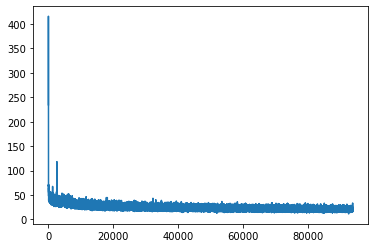

epoch: 51 	 step:0 	 loss: 20.76
epoch: 51 	 step:100 	 loss: 19.31
epoch: 51 	 step:200 	 loss: 30.34
epoch: 51 	 step:300 	 loss: 17.65
epoch: 51 	 step:400 	 loss: 23.57
epoch: 51 	 step:500 	 loss: 19.13
epoch: 51 	 step:600 	 loss: 22.08
epoch: 51 	 step:700 	 loss: 20.93
epoch: 51 	 step:800 	 loss: 17.45
epoch: 51 	 step:900 	 loss: 25.58
epoch: 51 	 step:1000 	 loss: 21.36
epoch: 51 	 step:1100 	 loss: 17.16
epoch: 51 	 step:1200 	 loss: 21.16
epoch: 51 	 step:1300 	 loss: 16.4
epoch: 51 	 step:1400 	 loss: 16.8
epoch: 51 	 step:1500 	 loss: 27.38
epoch: 51 	 step:1600 	 loss: 21.96
epoch: 51 	 step:1700 	 loss: 22.85
epoch: 51 	 step:1800 	 loss: 21.25


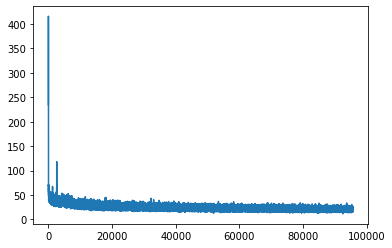

epoch: 52 	 step:0 	 loss: 23.52
epoch: 52 	 step:100 	 loss: 19.55
epoch: 52 	 step:200 	 loss: 19.69
epoch: 52 	 step:300 	 loss: 23.4
epoch: 52 	 step:400 	 loss: 21.37
epoch: 52 	 step:500 	 loss: 20.05
epoch: 52 	 step:600 	 loss: 16.31
epoch: 52 	 step:700 	 loss: 18.93
epoch: 52 	 step:800 	 loss: 22.61
epoch: 52 	 step:900 	 loss: 20.44
epoch: 52 	 step:1000 	 loss: 20.25
epoch: 52 	 step:1100 	 loss: 19.4
epoch: 52 	 step:1200 	 loss: 27.1
epoch: 52 	 step:1300 	 loss: 18.25
epoch: 52 	 step:1400 	 loss: 16.65
epoch: 52 	 step:1500 	 loss: 17.35
epoch: 52 	 step:1600 	 loss: 18.91
epoch: 52 	 step:1700 	 loss: 16.36
epoch: 52 	 step:1800 	 loss: 17.65


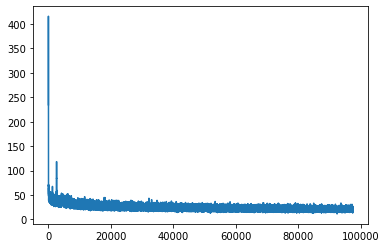

epoch: 53 	 step:0 	 loss: 20.08
epoch: 53 	 step:100 	 loss: 23.27
epoch: 53 	 step:200 	 loss: 18.1
epoch: 53 	 step:300 	 loss: 17.86
epoch: 53 	 step:400 	 loss: 14.87
epoch: 53 	 step:500 	 loss: 19.29
epoch: 53 	 step:600 	 loss: 18.78
epoch: 53 	 step:700 	 loss: 17.9
epoch: 53 	 step:800 	 loss: 19.28
epoch: 53 	 step:900 	 loss: 19.63
epoch: 53 	 step:1000 	 loss: 21.79
epoch: 53 	 step:1100 	 loss: 19.1
epoch: 53 	 step:1200 	 loss: 15.2
epoch: 53 	 step:1300 	 loss: 18.21
epoch: 53 	 step:1400 	 loss: 21.49
epoch: 53 	 step:1500 	 loss: 20.69
epoch: 53 	 step:1600 	 loss: 17.85
epoch: 53 	 step:1700 	 loss: 18.12
epoch: 53 	 step:1800 	 loss: 20.63


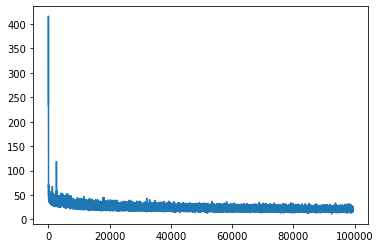

epoch: 54 	 step:0 	 loss: 17.98
epoch: 54 	 step:100 	 loss: 19.04
epoch: 54 	 step:200 	 loss: 18.3
epoch: 54 	 step:300 	 loss: 17.64
epoch: 54 	 step:400 	 loss: 19.86
epoch: 54 	 step:500 	 loss: 19.43
epoch: 54 	 step:600 	 loss: 19.4
epoch: 54 	 step:700 	 loss: 21.78
epoch: 54 	 step:800 	 loss: 18.21
epoch: 54 	 step:900 	 loss: 20.99
epoch: 54 	 step:1000 	 loss: 18.32
epoch: 54 	 step:1100 	 loss: 17.87
epoch: 54 	 step:1200 	 loss: 18.64
epoch: 54 	 step:1300 	 loss: 17.62
epoch: 54 	 step:1400 	 loss: 21.77
epoch: 54 	 step:1500 	 loss: 20.61
epoch: 54 	 step:1600 	 loss: 20.94
epoch: 54 	 step:1700 	 loss: 20.49
epoch: 54 	 step:1800 	 loss: 20.05


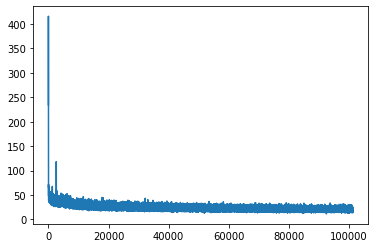

epoch: 55 	 step:0 	 loss: 23.68
epoch: 55 	 step:100 	 loss: 23.54
epoch: 55 	 step:200 	 loss: 18.73
epoch: 55 	 step:300 	 loss: 15.55
epoch: 55 	 step:400 	 loss: 20.9
epoch: 55 	 step:500 	 loss: 19.93
epoch: 55 	 step:600 	 loss: 21.52
epoch: 55 	 step:700 	 loss: 21.9
epoch: 55 	 step:800 	 loss: 21.65
epoch: 55 	 step:900 	 loss: 25.22
epoch: 55 	 step:1000 	 loss: 19.9
epoch: 55 	 step:1100 	 loss: 25.07
epoch: 55 	 step:1200 	 loss: 20.32
epoch: 55 	 step:1300 	 loss: 21.27
epoch: 55 	 step:1400 	 loss: 22.1
epoch: 55 	 step:1500 	 loss: 19.73
epoch: 55 	 step:1600 	 loss: 17.37
epoch: 55 	 step:1700 	 loss: 19.46
epoch: 55 	 step:1800 	 loss: 18.45


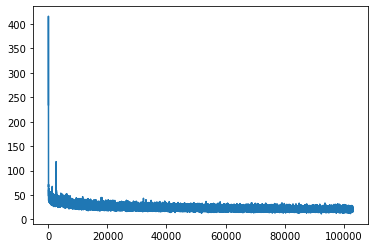

epoch: 56 	 step:0 	 loss: 24.14
epoch: 56 	 step:100 	 loss: 16.49
epoch: 56 	 step:200 	 loss: 19.96
epoch: 56 	 step:300 	 loss: 14.59
epoch: 56 	 step:400 	 loss: 24.07
epoch: 56 	 step:500 	 loss: 21.14
epoch: 56 	 step:600 	 loss: 17.37
epoch: 56 	 step:700 	 loss: 18.42
epoch: 56 	 step:800 	 loss: 18.04
epoch: 56 	 step:900 	 loss: 16.85
epoch: 56 	 step:1000 	 loss: 19.22
epoch: 56 	 step:1100 	 loss: 20.67
epoch: 56 	 step:1200 	 loss: 23.53
epoch: 56 	 step:1300 	 loss: 22.92
epoch: 56 	 step:1400 	 loss: 22.35
epoch: 56 	 step:1500 	 loss: 21.08
epoch: 56 	 step:1600 	 loss: 18.6
epoch: 56 	 step:1700 	 loss: 21.65
epoch: 56 	 step:1800 	 loss: 18.1


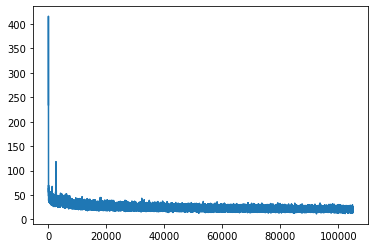

epoch: 57 	 step:0 	 loss: 21.28
epoch: 57 	 step:100 	 loss: 21.19
epoch: 57 	 step:200 	 loss: 17.9
epoch: 57 	 step:300 	 loss: 16.95
epoch: 57 	 step:400 	 loss: 28.77
epoch: 57 	 step:500 	 loss: 25.86
epoch: 57 	 step:600 	 loss: 23.59
epoch: 57 	 step:700 	 loss: 18.17
epoch: 57 	 step:800 	 loss: 17.63
epoch: 57 	 step:900 	 loss: 18.23
epoch: 57 	 step:1000 	 loss: 20.51
epoch: 57 	 step:1100 	 loss: 19.36
epoch: 57 	 step:1200 	 loss: 18.75
epoch: 57 	 step:1300 	 loss: 18.85
epoch: 57 	 step:1400 	 loss: 18.5
epoch: 57 	 step:1500 	 loss: 21.07
epoch: 57 	 step:1600 	 loss: 15.54
epoch: 57 	 step:1700 	 loss: 23.2
epoch: 57 	 step:1800 	 loss: 22.68


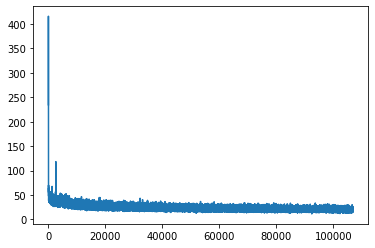

epoch: 58 	 step:0 	 loss: 18.39
epoch: 58 	 step:100 	 loss: 19.36
epoch: 58 	 step:200 	 loss: 24.25
epoch: 58 	 step:300 	 loss: 21.59
epoch: 58 	 step:400 	 loss: 22.75
epoch: 58 	 step:500 	 loss: 20.25
epoch: 58 	 step:600 	 loss: 21.1
epoch: 58 	 step:700 	 loss: 22.66
epoch: 58 	 step:800 	 loss: 20.15
epoch: 58 	 step:900 	 loss: 20.29
epoch: 58 	 step:1000 	 loss: 21.13
epoch: 58 	 step:1100 	 loss: 17.91
epoch: 58 	 step:1200 	 loss: 21.22
epoch: 58 	 step:1300 	 loss: 20.77
epoch: 58 	 step:1400 	 loss: 17.55
epoch: 58 	 step:1500 	 loss: 20.82
epoch: 58 	 step:1600 	 loss: 18.37
epoch: 58 	 step:1700 	 loss: 19.02
epoch: 58 	 step:1800 	 loss: 23.64


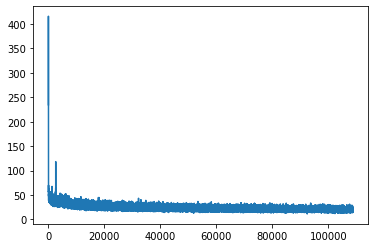

epoch: 59 	 step:0 	 loss: 18.97
epoch: 59 	 step:100 	 loss: 20.41
epoch: 59 	 step:200 	 loss: 17.4
epoch: 59 	 step:300 	 loss: 15.49
epoch: 59 	 step:400 	 loss: 21.84
epoch: 59 	 step:500 	 loss: 18.14
epoch: 59 	 step:600 	 loss: 21.22
epoch: 59 	 step:700 	 loss: 20.18
epoch: 59 	 step:800 	 loss: 18.2
epoch: 59 	 step:900 	 loss: 22.62
epoch: 59 	 step:1000 	 loss: 22.06
epoch: 59 	 step:1100 	 loss: 15.74
epoch: 59 	 step:1200 	 loss: 20.19
epoch: 59 	 step:1300 	 loss: 19.69
epoch: 59 	 step:1400 	 loss: 20.43
epoch: 59 	 step:1500 	 loss: 19.92
epoch: 59 	 step:1600 	 loss: 22.15
epoch: 59 	 step:1700 	 loss: 20.34
epoch: 59 	 step:1800 	 loss: 17.95


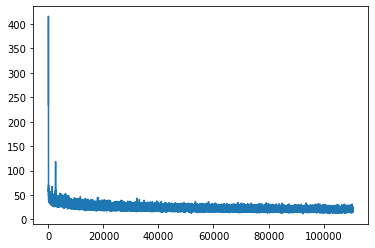

epoch: 60 	 step:0 	 loss: 19.31
epoch: 60 	 step:100 	 loss: 14.02
epoch: 60 	 step:200 	 loss: 24.72
epoch: 60 	 step:300 	 loss: 17.64
epoch: 60 	 step:400 	 loss: 20.32
epoch: 60 	 step:500 	 loss: 17.54
epoch: 60 	 step:600 	 loss: 20.58
epoch: 60 	 step:700 	 loss: 24.84
epoch: 60 	 step:800 	 loss: 18.07
epoch: 60 	 step:900 	 loss: 20.87
epoch: 60 	 step:1000 	 loss: 18.3
epoch: 60 	 step:1100 	 loss: 15.94
epoch: 60 	 step:1200 	 loss: 18.04
epoch: 60 	 step:1300 	 loss: 19.23
epoch: 60 	 step:1400 	 loss: 16.2
epoch: 60 	 step:1500 	 loss: 17.33
epoch: 60 	 step:1600 	 loss: 20.02
epoch: 60 	 step:1700 	 loss: 22.25
epoch: 60 	 step:1800 	 loss: 19.26


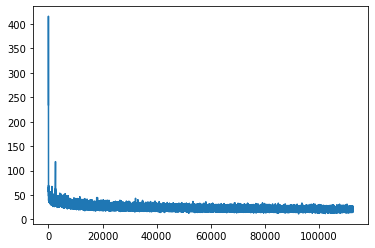

epoch: 61 	 step:0 	 loss: 17.64
epoch: 61 	 step:100 	 loss: 19.71
epoch: 61 	 step:200 	 loss: 19.35
epoch: 61 	 step:300 	 loss: 22.48
epoch: 61 	 step:400 	 loss: 23.46
epoch: 61 	 step:500 	 loss: 17.82
epoch: 61 	 step:600 	 loss: 23.1
epoch: 61 	 step:700 	 loss: 21.34
epoch: 61 	 step:800 	 loss: 20.91
epoch: 61 	 step:900 	 loss: 15.26
epoch: 61 	 step:1000 	 loss: 19.49
epoch: 61 	 step:1100 	 loss: 21.66
epoch: 61 	 step:1200 	 loss: 17.18
epoch: 61 	 step:1300 	 loss: 22.53
epoch: 61 	 step:1400 	 loss: 17.0
epoch: 61 	 step:1500 	 loss: 20.2
epoch: 61 	 step:1600 	 loss: 20.02
epoch: 61 	 step:1700 	 loss: 22.93
epoch: 61 	 step:1800 	 loss: 18.21


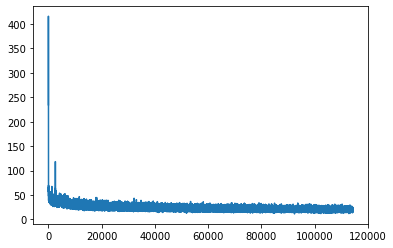

epoch: 62 	 step:0 	 loss: 17.38
epoch: 62 	 step:100 	 loss: 21.12
epoch: 62 	 step:200 	 loss: 20.51
epoch: 62 	 step:300 	 loss: 20.56
epoch: 62 	 step:400 	 loss: 23.44
epoch: 62 	 step:500 	 loss: 17.79
epoch: 62 	 step:600 	 loss: 18.62
epoch: 62 	 step:700 	 loss: 19.72
epoch: 62 	 step:800 	 loss: 16.56
epoch: 62 	 step:900 	 loss: 20.86
epoch: 62 	 step:1000 	 loss: 18.5
epoch: 62 	 step:1100 	 loss: 16.88
epoch: 62 	 step:1200 	 loss: 21.11
epoch: 62 	 step:1300 	 loss: 19.24
epoch: 62 	 step:1400 	 loss: 21.82
epoch: 62 	 step:1500 	 loss: 19.34
epoch: 62 	 step:1600 	 loss: 17.08
epoch: 62 	 step:1700 	 loss: 14.98
epoch: 62 	 step:1800 	 loss: 21.03


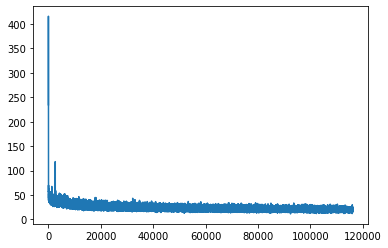

epoch: 63 	 step:0 	 loss: 17.99
epoch: 63 	 step:100 	 loss: 15.11
epoch: 63 	 step:200 	 loss: 20.06
epoch: 63 	 step:300 	 loss: 18.66
epoch: 63 	 step:400 	 loss: 17.79
epoch: 63 	 step:500 	 loss: 19.8
epoch: 63 	 step:600 	 loss: 16.81
epoch: 63 	 step:700 	 loss: 21.9
epoch: 63 	 step:800 	 loss: 16.55
epoch: 63 	 step:900 	 loss: 20.73
epoch: 63 	 step:1000 	 loss: 24.72
epoch: 63 	 step:1100 	 loss: 18.62
epoch: 63 	 step:1200 	 loss: 14.95
epoch: 63 	 step:1300 	 loss: 18.08
epoch: 63 	 step:1400 	 loss: 20.3
epoch: 63 	 step:1500 	 loss: 18.98
epoch: 63 	 step:1600 	 loss: 14.53
epoch: 63 	 step:1700 	 loss: 22.48
epoch: 63 	 step:1800 	 loss: 16.43


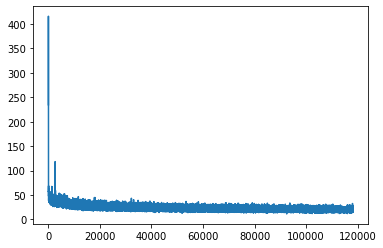

epoch: 64 	 step:0 	 loss: 20.52
epoch: 64 	 step:100 	 loss: 19.58
epoch: 64 	 step:200 	 loss: 20.36
epoch: 64 	 step:300 	 loss: 17.22
epoch: 64 	 step:400 	 loss: 23.14
epoch: 64 	 step:500 	 loss: 15.4
epoch: 64 	 step:600 	 loss: 19.48
epoch: 64 	 step:700 	 loss: 18.82
epoch: 64 	 step:800 	 loss: 15.72
epoch: 64 	 step:900 	 loss: 19.72
epoch: 64 	 step:1000 	 loss: 15.67
epoch: 64 	 step:1100 	 loss: 20.25
epoch: 64 	 step:1200 	 loss: 18.46
epoch: 64 	 step:1300 	 loss: 18.32
epoch: 64 	 step:1400 	 loss: 24.31
epoch: 64 	 step:1500 	 loss: 22.47
epoch: 64 	 step:1600 	 loss: 19.71
epoch: 64 	 step:1700 	 loss: 17.21
epoch: 64 	 step:1800 	 loss: 18.27


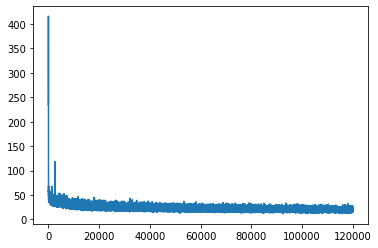

epoch: 65 	 step:0 	 loss: 18.14
epoch: 65 	 step:100 	 loss: 16.15
epoch: 65 	 step:200 	 loss: 16.86
epoch: 65 	 step:300 	 loss: 19.01
epoch: 65 	 step:400 	 loss: 19.97
epoch: 65 	 step:500 	 loss: 14.64
epoch: 65 	 step:600 	 loss: 16.15
epoch: 65 	 step:700 	 loss: 14.84
epoch: 65 	 step:800 	 loss: 16.93
epoch: 65 	 step:900 	 loss: 20.08
epoch: 65 	 step:1000 	 loss: 20.52
epoch: 65 	 step:1100 	 loss: 20.23
epoch: 65 	 step:1200 	 loss: 16.92
epoch: 65 	 step:1300 	 loss: 17.82
epoch: 65 	 step:1400 	 loss: 23.39
epoch: 65 	 step:1500 	 loss: 16.82
epoch: 65 	 step:1600 	 loss: 18.96
epoch: 65 	 step:1700 	 loss: 20.73
epoch: 65 	 step:1800 	 loss: 17.83


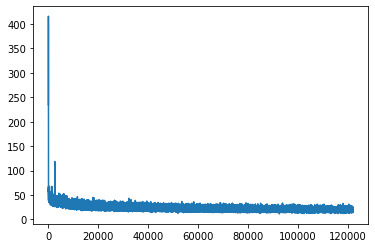

epoch: 66 	 step:0 	 loss: 18.87
epoch: 66 	 step:100 	 loss: 21.33
epoch: 66 	 step:200 	 loss: 20.96
epoch: 66 	 step:300 	 loss: 19.26
epoch: 66 	 step:400 	 loss: 21.23
epoch: 66 	 step:500 	 loss: 20.12
epoch: 66 	 step:600 	 loss: 15.55
epoch: 66 	 step:700 	 loss: 19.05
epoch: 66 	 step:800 	 loss: 18.57
epoch: 66 	 step:900 	 loss: 21.27
epoch: 66 	 step:1000 	 loss: 16.03
epoch: 66 	 step:1100 	 loss: 18.93
epoch: 66 	 step:1200 	 loss: 22.14
epoch: 66 	 step:1300 	 loss: 19.78
epoch: 66 	 step:1400 	 loss: 16.98
epoch: 66 	 step:1500 	 loss: 16.82
epoch: 66 	 step:1600 	 loss: 18.7
epoch: 66 	 step:1700 	 loss: 21.34
epoch: 66 	 step:1800 	 loss: 19.81


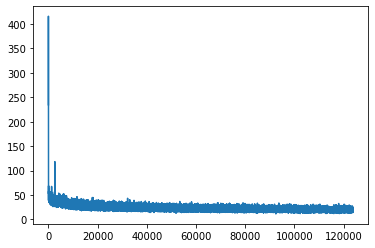

epoch: 67 	 step:0 	 loss: 19.2
epoch: 67 	 step:100 	 loss: 19.5
epoch: 67 	 step:200 	 loss: 21.99
epoch: 67 	 step:300 	 loss: 20.86
epoch: 67 	 step:400 	 loss: 19.74
epoch: 67 	 step:500 	 loss: 19.89
epoch: 67 	 step:600 	 loss: 16.38
epoch: 67 	 step:700 	 loss: 19.67
epoch: 67 	 step:800 	 loss: 25.43
epoch: 67 	 step:900 	 loss: 20.12
epoch: 67 	 step:1000 	 loss: 19.13
epoch: 67 	 step:1100 	 loss: 30.13
epoch: 67 	 step:1200 	 loss: 19.59
epoch: 67 	 step:1300 	 loss: 17.41
epoch: 67 	 step:1400 	 loss: 17.95
epoch: 67 	 step:1500 	 loss: 18.01
epoch: 67 	 step:1600 	 loss: 17.24
epoch: 67 	 step:1700 	 loss: 20.8
epoch: 67 	 step:1800 	 loss: 18.46


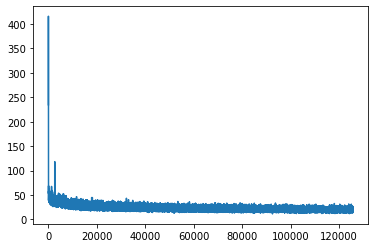

epoch: 68 	 step:0 	 loss: 18.25
epoch: 68 	 step:100 	 loss: 18.54
epoch: 68 	 step:200 	 loss: 21.28
epoch: 68 	 step:300 	 loss: 16.26
epoch: 68 	 step:400 	 loss: 19.07
epoch: 68 	 step:500 	 loss: 18.84
epoch: 68 	 step:600 	 loss: 21.08
epoch: 68 	 step:700 	 loss: 18.55
epoch: 68 	 step:800 	 loss: 14.2
epoch: 68 	 step:900 	 loss: 16.82
epoch: 68 	 step:1000 	 loss: 20.37
epoch: 68 	 step:1100 	 loss: 17.9
epoch: 68 	 step:1200 	 loss: 19.04
epoch: 68 	 step:1300 	 loss: 24.42
epoch: 68 	 step:1400 	 loss: 18.76
epoch: 68 	 step:1500 	 loss: 15.17
epoch: 68 	 step:1600 	 loss: 21.16
epoch: 68 	 step:1700 	 loss: 16.56
epoch: 68 	 step:1800 	 loss: 18.98


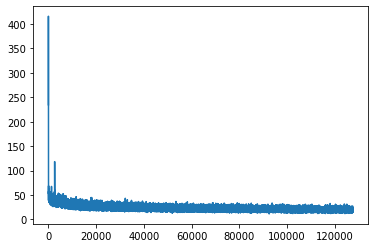

epoch: 69 	 step:0 	 loss: 19.24
epoch: 69 	 step:100 	 loss: 14.99
epoch: 69 	 step:200 	 loss: 22.01
epoch: 69 	 step:300 	 loss: 18.47
epoch: 69 	 step:400 	 loss: 19.5
epoch: 69 	 step:500 	 loss: 14.95
epoch: 69 	 step:600 	 loss: 17.08
epoch: 69 	 step:700 	 loss: 15.06
epoch: 69 	 step:800 	 loss: 17.78
epoch: 69 	 step:900 	 loss: 15.68
epoch: 69 	 step:1000 	 loss: 17.86
epoch: 69 	 step:1100 	 loss: 17.0
epoch: 69 	 step:1200 	 loss: 23.19
epoch: 69 	 step:1300 	 loss: 15.5
epoch: 69 	 step:1400 	 loss: 18.08
epoch: 69 	 step:1500 	 loss: 17.1
epoch: 69 	 step:1600 	 loss: 18.88
epoch: 69 	 step:1700 	 loss: 19.64
epoch: 69 	 step:1800 	 loss: 24.78


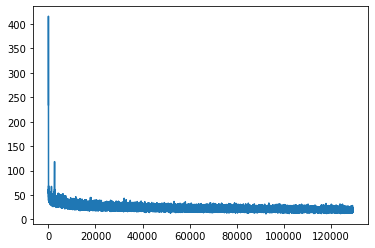

epoch: 70 	 step:0 	 loss: 25.24
epoch: 70 	 step:100 	 loss: 22.79
epoch: 70 	 step:200 	 loss: 22.39
epoch: 70 	 step:300 	 loss: 22.89
epoch: 70 	 step:400 	 loss: 17.62
epoch: 70 	 step:500 	 loss: 17.72
epoch: 70 	 step:600 	 loss: 18.47
epoch: 70 	 step:700 	 loss: 18.99
epoch: 70 	 step:800 	 loss: 21.07
epoch: 70 	 step:900 	 loss: 15.11
epoch: 70 	 step:1000 	 loss: 18.4
epoch: 70 	 step:1100 	 loss: 19.31
epoch: 70 	 step:1200 	 loss: 17.05
epoch: 70 	 step:1300 	 loss: 20.98
epoch: 70 	 step:1400 	 loss: 22.23
epoch: 70 	 step:1500 	 loss: 23.95
epoch: 70 	 step:1600 	 loss: 17.45
epoch: 70 	 step:1700 	 loss: 17.9
epoch: 70 	 step:1800 	 loss: 18.23


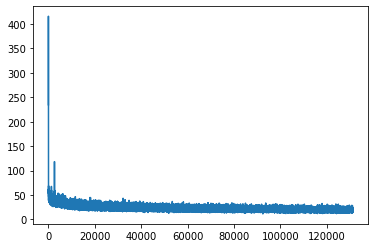

epoch: 71 	 step:0 	 loss: 23.77
epoch: 71 	 step:100 	 loss: 22.41
epoch: 71 	 step:200 	 loss: 15.41
epoch: 71 	 step:300 	 loss: 17.34
epoch: 71 	 step:400 	 loss: 21.06
epoch: 71 	 step:500 	 loss: 19.35
epoch: 71 	 step:600 	 loss: 18.51
epoch: 71 	 step:700 	 loss: 19.54
epoch: 71 	 step:800 	 loss: 14.32
epoch: 71 	 step:900 	 loss: 21.73
epoch: 71 	 step:1000 	 loss: 19.11
epoch: 71 	 step:1100 	 loss: 18.17
epoch: 71 	 step:1200 	 loss: 16.44
epoch: 71 	 step:1300 	 loss: 19.83
epoch: 71 	 step:1400 	 loss: 19.85
epoch: 71 	 step:1500 	 loss: 18.94
epoch: 71 	 step:1600 	 loss: 19.72
epoch: 71 	 step:1700 	 loss: 22.82
epoch: 71 	 step:1800 	 loss: 15.39


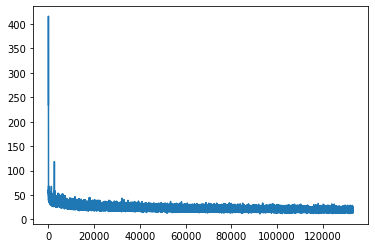

epoch: 72 	 step:0 	 loss: 17.45
epoch: 72 	 step:100 	 loss: 17.81
epoch: 72 	 step:200 	 loss: 16.03
epoch: 72 	 step:300 	 loss: 15.17
epoch: 72 	 step:400 	 loss: 18.55
epoch: 72 	 step:500 	 loss: 20.36
epoch: 72 	 step:600 	 loss: 20.38
epoch: 72 	 step:700 	 loss: 19.93
epoch: 72 	 step:800 	 loss: 20.18
epoch: 72 	 step:900 	 loss: 16.42
epoch: 72 	 step:1000 	 loss: 22.23
epoch: 72 	 step:1100 	 loss: 18.62
epoch: 72 	 step:1200 	 loss: 16.93
epoch: 72 	 step:1300 	 loss: 21.75
epoch: 72 	 step:1400 	 loss: 20.27
epoch: 72 	 step:1500 	 loss: 16.84
epoch: 72 	 step:1600 	 loss: 14.28
epoch: 72 	 step:1700 	 loss: 18.39
epoch: 72 	 step:1800 	 loss: 21.91


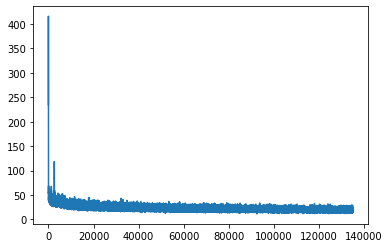

epoch: 73 	 step:0 	 loss: 21.29
epoch: 73 	 step:100 	 loss: 16.94
epoch: 73 	 step:200 	 loss: 20.62
epoch: 73 	 step:300 	 loss: 18.5
epoch: 73 	 step:400 	 loss: 18.03
epoch: 73 	 step:500 	 loss: 19.54
epoch: 73 	 step:600 	 loss: 22.78
epoch: 73 	 step:700 	 loss: 20.34
epoch: 73 	 step:800 	 loss: 19.63
epoch: 73 	 step:900 	 loss: 14.48
epoch: 73 	 step:1000 	 loss: 15.87
epoch: 73 	 step:1100 	 loss: 14.14
epoch: 73 	 step:1200 	 loss: 22.04
epoch: 73 	 step:1300 	 loss: 19.99
epoch: 73 	 step:1400 	 loss: 15.28
epoch: 73 	 step:1500 	 loss: 19.65
epoch: 73 	 step:1600 	 loss: 17.29
epoch: 73 	 step:1700 	 loss: 15.04
epoch: 73 	 step:1800 	 loss: 17.43


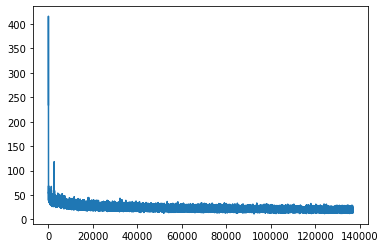

epoch: 74 	 step:0 	 loss: 19.62
epoch: 74 	 step:100 	 loss: 18.38
epoch: 74 	 step:200 	 loss: 21.94
epoch: 74 	 step:300 	 loss: 19.58
epoch: 74 	 step:400 	 loss: 17.63
epoch: 74 	 step:500 	 loss: 18.47
epoch: 74 	 step:600 	 loss: 21.13
epoch: 74 	 step:700 	 loss: 17.99
epoch: 74 	 step:800 	 loss: 16.44
epoch: 74 	 step:900 	 loss: 20.75
epoch: 74 	 step:1000 	 loss: 16.43
epoch: 74 	 step:1100 	 loss: 21.27
epoch: 74 	 step:1200 	 loss: 15.54
epoch: 74 	 step:1300 	 loss: 17.62
epoch: 74 	 step:1400 	 loss: 19.0
epoch: 74 	 step:1500 	 loss: 18.02
epoch: 74 	 step:1600 	 loss: 21.19
epoch: 74 	 step:1700 	 loss: 20.91
epoch: 74 	 step:1800 	 loss: 19.6


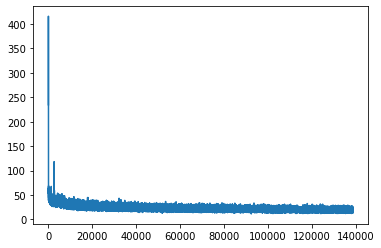

epoch: 75 	 step:0 	 loss: 14.77
epoch: 75 	 step:100 	 loss: 16.57
epoch: 75 	 step:200 	 loss: 14.67
epoch: 75 	 step:300 	 loss: 21.32
epoch: 75 	 step:400 	 loss: 20.46
epoch: 75 	 step:500 	 loss: 23.59
epoch: 75 	 step:600 	 loss: 18.9
epoch: 75 	 step:700 	 loss: 19.14
epoch: 75 	 step:800 	 loss: 16.1
epoch: 75 	 step:900 	 loss: 21.43
epoch: 75 	 step:1000 	 loss: 19.19
epoch: 75 	 step:1100 	 loss: 21.94
epoch: 75 	 step:1200 	 loss: 16.97
epoch: 75 	 step:1300 	 loss: 17.68
epoch: 75 	 step:1400 	 loss: 15.86
epoch: 75 	 step:1500 	 loss: 20.02
epoch: 75 	 step:1600 	 loss: 17.04
epoch: 75 	 step:1700 	 loss: 13.72
epoch: 75 	 step:1800 	 loss: 19.53


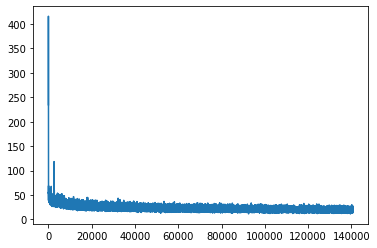

epoch: 76 	 step:0 	 loss: 17.47
epoch: 76 	 step:100 	 loss: 18.75
epoch: 76 	 step:200 	 loss: 15.19
epoch: 76 	 step:300 	 loss: 17.57
epoch: 76 	 step:400 	 loss: 21.64
epoch: 76 	 step:500 	 loss: 18.99
epoch: 76 	 step:600 	 loss: 19.57
epoch: 76 	 step:700 	 loss: 18.16
epoch: 76 	 step:800 	 loss: 17.6
epoch: 76 	 step:900 	 loss: 18.9
epoch: 76 	 step:1000 	 loss: 19.88
epoch: 76 	 step:1100 	 loss: 20.15
epoch: 76 	 step:1200 	 loss: 21.28
epoch: 76 	 step:1300 	 loss: 18.43
epoch: 76 	 step:1400 	 loss: 18.81
epoch: 76 	 step:1500 	 loss: 22.51
epoch: 76 	 step:1600 	 loss: 22.6
epoch: 76 	 step:1700 	 loss: 17.28
epoch: 76 	 step:1800 	 loss: 22.82


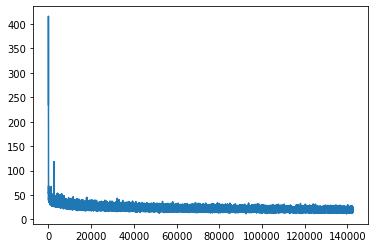

epoch: 77 	 step:0 	 loss: 14.67
epoch: 77 	 step:100 	 loss: 18.0
epoch: 77 	 step:200 	 loss: 16.23
epoch: 77 	 step:300 	 loss: 17.59
epoch: 77 	 step:400 	 loss: 14.4
epoch: 77 	 step:500 	 loss: 22.03
epoch: 77 	 step:600 	 loss: 18.92
epoch: 77 	 step:700 	 loss: 17.97
epoch: 77 	 step:800 	 loss: 15.96
epoch: 77 	 step:900 	 loss: 21.47
epoch: 77 	 step:1000 	 loss: 19.02
epoch: 77 	 step:1100 	 loss: 18.52
epoch: 77 	 step:1200 	 loss: 19.25
epoch: 77 	 step:1300 	 loss: 15.3
epoch: 77 	 step:1400 	 loss: 19.51
epoch: 77 	 step:1500 	 loss: 19.85
epoch: 77 	 step:1600 	 loss: 16.14
epoch: 77 	 step:1700 	 loss: 18.62
epoch: 77 	 step:1800 	 loss: 17.28


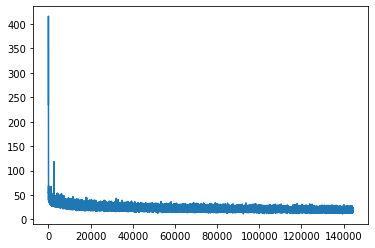

epoch: 78 	 step:0 	 loss: 19.68
epoch: 78 	 step:100 	 loss: 16.8
epoch: 78 	 step:200 	 loss: 16.25
epoch: 78 	 step:300 	 loss: 19.2
epoch: 78 	 step:400 	 loss: 17.4
epoch: 78 	 step:500 	 loss: 16.8
epoch: 78 	 step:600 	 loss: 17.94
epoch: 78 	 step:700 	 loss: 15.86
epoch: 78 	 step:800 	 loss: 19.7
epoch: 78 	 step:900 	 loss: 20.93
epoch: 78 	 step:1000 	 loss: 16.97
epoch: 78 	 step:1100 	 loss: 24.92
epoch: 78 	 step:1200 	 loss: 19.0
epoch: 78 	 step:1300 	 loss: 16.65
epoch: 78 	 step:1400 	 loss: 19.7
epoch: 78 	 step:1500 	 loss: 17.89
epoch: 78 	 step:1600 	 loss: 20.1
epoch: 78 	 step:1700 	 loss: 16.95
epoch: 78 	 step:1800 	 loss: 18.46


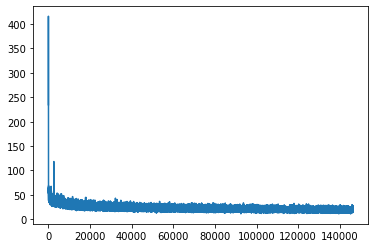

epoch: 79 	 step:0 	 loss: 19.77
epoch: 79 	 step:100 	 loss: 18.29
epoch: 79 	 step:200 	 loss: 20.15
epoch: 79 	 step:300 	 loss: 16.58
epoch: 79 	 step:400 	 loss: 18.42
epoch: 79 	 step:500 	 loss: 18.25
epoch: 79 	 step:600 	 loss: 20.57
epoch: 79 	 step:700 	 loss: 11.47
epoch: 79 	 step:800 	 loss: 19.66
epoch: 79 	 step:900 	 loss: 22.3
epoch: 79 	 step:1000 	 loss: 15.73
epoch: 79 	 step:1100 	 loss: 21.67
epoch: 79 	 step:1200 	 loss: 21.61
epoch: 79 	 step:1300 	 loss: 18.44
epoch: 79 	 step:1400 	 loss: 22.74
epoch: 79 	 step:1500 	 loss: 16.32
epoch: 79 	 step:1600 	 loss: 15.14
epoch: 79 	 step:1700 	 loss: 20.67
epoch: 79 	 step:1800 	 loss: 23.75


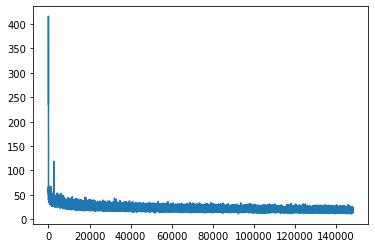

epoch: 80 	 step:0 	 loss: 17.0
epoch: 80 	 step:100 	 loss: 23.52
epoch: 80 	 step:200 	 loss: 16.46
epoch: 80 	 step:300 	 loss: 18.14
epoch: 80 	 step:400 	 loss: 18.6
epoch: 80 	 step:500 	 loss: 18.01
epoch: 80 	 step:600 	 loss: 21.54
epoch: 80 	 step:700 	 loss: 19.19
epoch: 80 	 step:800 	 loss: 20.72
epoch: 80 	 step:900 	 loss: 17.95
epoch: 80 	 step:1000 	 loss: 15.26
epoch: 80 	 step:1100 	 loss: 19.14
epoch: 80 	 step:1200 	 loss: 20.04
epoch: 80 	 step:1300 	 loss: 16.32
epoch: 80 	 step:1400 	 loss: 15.76
epoch: 80 	 step:1500 	 loss: 19.92
epoch: 80 	 step:1600 	 loss: 18.85
epoch: 80 	 step:1700 	 loss: 19.7
epoch: 80 	 step:1800 	 loss: 22.47


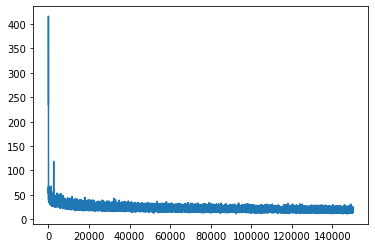

epoch: 81 	 step:0 	 loss: 20.54
epoch: 81 	 step:100 	 loss: 18.37
epoch: 81 	 step:200 	 loss: 19.22
epoch: 81 	 step:300 	 loss: 21.15
epoch: 81 	 step:400 	 loss: 19.73
epoch: 81 	 step:500 	 loss: 20.58
epoch: 81 	 step:600 	 loss: 24.95
epoch: 81 	 step:700 	 loss: 17.05
epoch: 81 	 step:800 	 loss: 18.64
epoch: 81 	 step:900 	 loss: 23.59
epoch: 81 	 step:1000 	 loss: 17.26
epoch: 81 	 step:1100 	 loss: 19.63
epoch: 81 	 step:1200 	 loss: 15.12
epoch: 81 	 step:1300 	 loss: 18.03
epoch: 81 	 step:1400 	 loss: 16.2
epoch: 81 	 step:1500 	 loss: 18.89
epoch: 81 	 step:1600 	 loss: 16.2
epoch: 81 	 step:1700 	 loss: 21.64
epoch: 81 	 step:1800 	 loss: 19.94


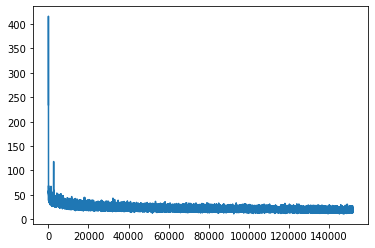

epoch: 82 	 step:0 	 loss: 17.03
epoch: 82 	 step:100 	 loss: 17.73
epoch: 82 	 step:200 	 loss: 17.65
epoch: 82 	 step:300 	 loss: 21.41
epoch: 82 	 step:400 	 loss: 19.37
epoch: 82 	 step:500 	 loss: 20.05
epoch: 82 	 step:600 	 loss: 15.27
epoch: 82 	 step:700 	 loss: 18.05
epoch: 82 	 step:800 	 loss: 17.48
epoch: 82 	 step:900 	 loss: 19.61
epoch: 82 	 step:1000 	 loss: 16.24
epoch: 82 	 step:1100 	 loss: 17.57
epoch: 82 	 step:1200 	 loss: 16.21
epoch: 82 	 step:1300 	 loss: 21.38
epoch: 82 	 step:1400 	 loss: 15.27
epoch: 82 	 step:1500 	 loss: 17.97
epoch: 82 	 step:1600 	 loss: 20.32
epoch: 82 	 step:1700 	 loss: 22.53
epoch: 82 	 step:1800 	 loss: 19.52


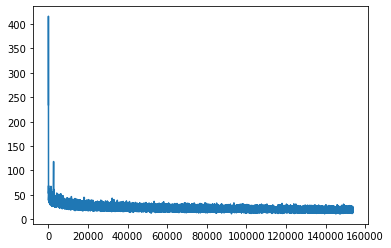

epoch: 83 	 step:0 	 loss: 14.5
epoch: 83 	 step:100 	 loss: 17.95
epoch: 83 	 step:200 	 loss: 18.19
epoch: 83 	 step:300 	 loss: 18.26
epoch: 83 	 step:400 	 loss: 18.47
epoch: 83 	 step:500 	 loss: 19.16
epoch: 83 	 step:600 	 loss: 16.4
epoch: 83 	 step:700 	 loss: 15.84
epoch: 83 	 step:800 	 loss: 15.43
epoch: 83 	 step:900 	 loss: 16.73
epoch: 83 	 step:1000 	 loss: 18.18
epoch: 83 	 step:1100 	 loss: 15.13
epoch: 83 	 step:1200 	 loss: 19.92
epoch: 83 	 step:1300 	 loss: 16.45
epoch: 83 	 step:1400 	 loss: 25.32
epoch: 83 	 step:1500 	 loss: 20.87
epoch: 83 	 step:1600 	 loss: 20.79
epoch: 83 	 step:1700 	 loss: 17.11
epoch: 83 	 step:1800 	 loss: 18.37


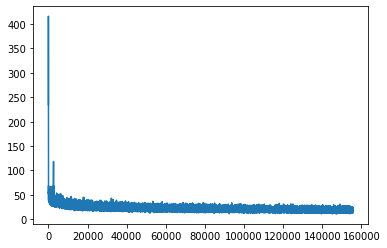

epoch: 84 	 step:0 	 loss: 14.84
epoch: 84 	 step:100 	 loss: 17.05
epoch: 84 	 step:200 	 loss: 17.77
epoch: 84 	 step:300 	 loss: 23.47
epoch: 84 	 step:400 	 loss: 17.39
epoch: 84 	 step:500 	 loss: 18.01
epoch: 84 	 step:600 	 loss: 16.36
epoch: 84 	 step:700 	 loss: 18.62
epoch: 84 	 step:800 	 loss: 21.68
epoch: 84 	 step:900 	 loss: 20.16
epoch: 84 	 step:1000 	 loss: 16.25
epoch: 84 	 step:1100 	 loss: 19.82
epoch: 84 	 step:1200 	 loss: 22.25
epoch: 84 	 step:1300 	 loss: 21.62
epoch: 84 	 step:1400 	 loss: 18.75
epoch: 84 	 step:1500 	 loss: 18.65
epoch: 84 	 step:1600 	 loss: 16.16
epoch: 84 	 step:1700 	 loss: 22.26
epoch: 84 	 step:1800 	 loss: 13.56


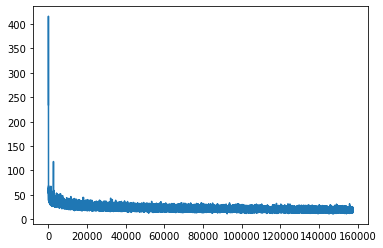

epoch: 85 	 step:0 	 loss: 16.6
epoch: 85 	 step:100 	 loss: 22.0
epoch: 85 	 step:200 	 loss: 19.85
epoch: 85 	 step:300 	 loss: 17.18
epoch: 85 	 step:400 	 loss: 14.32
epoch: 85 	 step:500 	 loss: 21.23
epoch: 85 	 step:600 	 loss: 16.24
epoch: 85 	 step:700 	 loss: 20.92
epoch: 85 	 step:800 	 loss: 20.31
epoch: 85 	 step:900 	 loss: 13.72
epoch: 85 	 step:1000 	 loss: 18.06
epoch: 85 	 step:1100 	 loss: 17.86
epoch: 85 	 step:1200 	 loss: 16.01
epoch: 85 	 step:1300 	 loss: 18.81
epoch: 85 	 step:1400 	 loss: 18.43
epoch: 85 	 step:1500 	 loss: 16.31
epoch: 85 	 step:1600 	 loss: 17.8
epoch: 85 	 step:1700 	 loss: 18.78
epoch: 85 	 step:1800 	 loss: 18.32


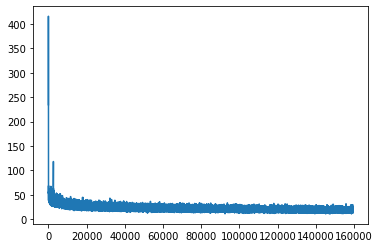

epoch: 86 	 step:0 	 loss: 17.21
epoch: 86 	 step:100 	 loss: 21.44
epoch: 86 	 step:200 	 loss: 16.54
epoch: 86 	 step:300 	 loss: 17.84
epoch: 86 	 step:400 	 loss: 23.2
epoch: 86 	 step:500 	 loss: 18.5
epoch: 86 	 step:600 	 loss: 17.92
epoch: 86 	 step:700 	 loss: 22.24
epoch: 86 	 step:800 	 loss: 15.31
epoch: 86 	 step:900 	 loss: 14.48
epoch: 86 	 step:1000 	 loss: 18.19
epoch: 86 	 step:1100 	 loss: 17.49
epoch: 86 	 step:1200 	 loss: 16.14
epoch: 86 	 step:1300 	 loss: 19.25
epoch: 86 	 step:1400 	 loss: 23.04
epoch: 86 	 step:1500 	 loss: 19.26
epoch: 86 	 step:1600 	 loss: 13.67
epoch: 86 	 step:1700 	 loss: 22.61
epoch: 86 	 step:1800 	 loss: 18.73


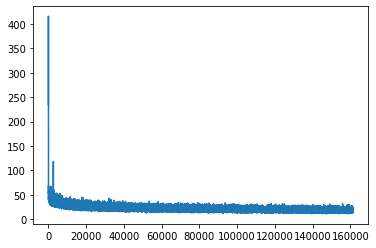

epoch: 87 	 step:0 	 loss: 19.27
epoch: 87 	 step:100 	 loss: 22.63
epoch: 87 	 step:200 	 loss: 17.1
epoch: 87 	 step:300 	 loss: 17.76
epoch: 87 	 step:400 	 loss: 24.03
epoch: 87 	 step:500 	 loss: 18.62
epoch: 87 	 step:600 	 loss: 20.61
epoch: 87 	 step:700 	 loss: 19.31
epoch: 87 	 step:800 	 loss: 19.65
epoch: 87 	 step:900 	 loss: 18.49
epoch: 87 	 step:1000 	 loss: 16.92
epoch: 87 	 step:1100 	 loss: 14.44
epoch: 87 	 step:1200 	 loss: 16.42
epoch: 87 	 step:1300 	 loss: 25.07
epoch: 87 	 step:1400 	 loss: 15.65
epoch: 87 	 step:1500 	 loss: 18.57
epoch: 87 	 step:1600 	 loss: 19.06
epoch: 87 	 step:1700 	 loss: 15.94
epoch: 87 	 step:1800 	 loss: 23.56


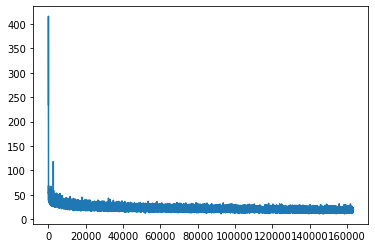

epoch: 88 	 step:0 	 loss: 13.84
epoch: 88 	 step:100 	 loss: 16.55
epoch: 88 	 step:200 	 loss: 18.16
epoch: 88 	 step:300 	 loss: 21.18
epoch: 88 	 step:400 	 loss: 17.52
epoch: 88 	 step:500 	 loss: 19.08
epoch: 88 	 step:600 	 loss: 17.33
epoch: 88 	 step:700 	 loss: 18.71
epoch: 88 	 step:800 	 loss: 19.63
epoch: 88 	 step:900 	 loss: 20.76
epoch: 88 	 step:1000 	 loss: 19.75
epoch: 88 	 step:1100 	 loss: 14.95
epoch: 88 	 step:1200 	 loss: 15.94
epoch: 88 	 step:1300 	 loss: 16.97
epoch: 88 	 step:1400 	 loss: 17.76
epoch: 88 	 step:1500 	 loss: 14.25
epoch: 88 	 step:1600 	 loss: 18.57
epoch: 88 	 step:1700 	 loss: 15.55
epoch: 88 	 step:1800 	 loss: 19.18


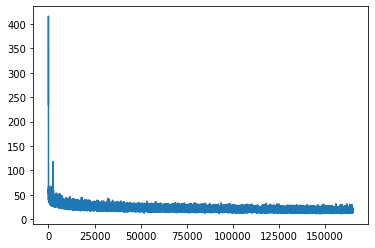

epoch: 89 	 step:0 	 loss: 14.6
epoch: 89 	 step:100 	 loss: 14.54
epoch: 89 	 step:200 	 loss: 18.43
epoch: 89 	 step:300 	 loss: 22.8
epoch: 89 	 step:400 	 loss: 21.65
epoch: 89 	 step:500 	 loss: 18.36
epoch: 89 	 step:600 	 loss: 18.7
epoch: 89 	 step:700 	 loss: 17.16
epoch: 89 	 step:800 	 loss: 18.54
epoch: 89 	 step:900 	 loss: 14.0
epoch: 89 	 step:1000 	 loss: 19.78
epoch: 89 	 step:1100 	 loss: 19.53
epoch: 89 	 step:1200 	 loss: 28.67
epoch: 89 	 step:1300 	 loss: 18.84
epoch: 89 	 step:1400 	 loss: 20.78
epoch: 89 	 step:1500 	 loss: 17.98
epoch: 89 	 step:1600 	 loss: 17.61
epoch: 89 	 step:1700 	 loss: 13.15
epoch: 89 	 step:1800 	 loss: 19.27


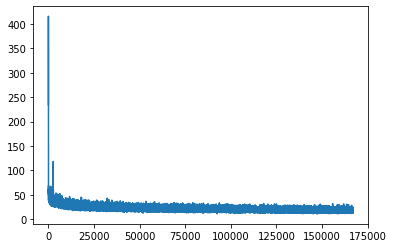

epoch: 90 	 step:0 	 loss: 18.44
epoch: 90 	 step:100 	 loss: 17.36
epoch: 90 	 step:200 	 loss: 17.19
epoch: 90 	 step:300 	 loss: 19.79
epoch: 90 	 step:400 	 loss: 18.43
epoch: 90 	 step:500 	 loss: 15.03
epoch: 90 	 step:600 	 loss: 19.45
epoch: 90 	 step:700 	 loss: 20.55
epoch: 90 	 step:800 	 loss: 23.29
epoch: 90 	 step:900 	 loss: 18.93
epoch: 90 	 step:1000 	 loss: 20.94
epoch: 90 	 step:1100 	 loss: 18.0
epoch: 90 	 step:1200 	 loss: 19.66
epoch: 90 	 step:1300 	 loss: 16.6
epoch: 90 	 step:1400 	 loss: 21.01
epoch: 90 	 step:1500 	 loss: 21.53
epoch: 90 	 step:1600 	 loss: 18.3
epoch: 90 	 step:1700 	 loss: 17.57
epoch: 90 	 step:1800 	 loss: 18.36


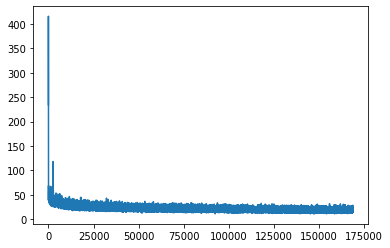

epoch: 91 	 step:0 	 loss: 21.97
epoch: 91 	 step:100 	 loss: 17.86
epoch: 91 	 step:200 	 loss: 19.08
epoch: 91 	 step:300 	 loss: 21.23
epoch: 91 	 step:400 	 loss: 18.35
epoch: 91 	 step:500 	 loss: 19.35
epoch: 91 	 step:600 	 loss: 17.04
epoch: 91 	 step:700 	 loss: 16.26
epoch: 91 	 step:800 	 loss: 16.61
epoch: 91 	 step:900 	 loss: 19.63
epoch: 91 	 step:1000 	 loss: 15.67
epoch: 91 	 step:1100 	 loss: 17.35
epoch: 91 	 step:1200 	 loss: 15.2
epoch: 91 	 step:1300 	 loss: 20.65
epoch: 91 	 step:1400 	 loss: 18.21
epoch: 91 	 step:1500 	 loss: 16.52
epoch: 91 	 step:1600 	 loss: 17.63
epoch: 91 	 step:1700 	 loss: 18.6
epoch: 91 	 step:1800 	 loss: 15.11


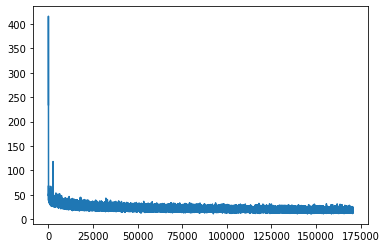

epoch: 92 	 step:0 	 loss: 21.05
epoch: 92 	 step:100 	 loss: 21.44
epoch: 92 	 step:200 	 loss: 19.57
epoch: 92 	 step:300 	 loss: 13.55
epoch: 92 	 step:400 	 loss: 19.94
epoch: 92 	 step:500 	 loss: 15.25
epoch: 92 	 step:600 	 loss: 21.34
epoch: 92 	 step:700 	 loss: 16.35
epoch: 92 	 step:800 	 loss: 16.84
epoch: 92 	 step:900 	 loss: 19.38
epoch: 92 	 step:1000 	 loss: 18.29
epoch: 92 	 step:1100 	 loss: 20.99
epoch: 92 	 step:1200 	 loss: 19.42
epoch: 92 	 step:1300 	 loss: 17.49
epoch: 92 	 step:1400 	 loss: 19.13
epoch: 92 	 step:1500 	 loss: 23.57
epoch: 92 	 step:1600 	 loss: 22.16
epoch: 92 	 step:1700 	 loss: 14.41
epoch: 92 	 step:1800 	 loss: 16.67


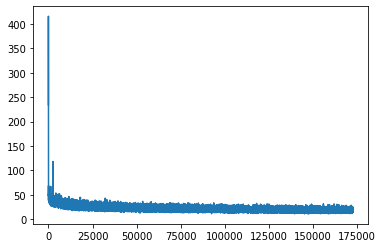

epoch: 93 	 step:0 	 loss: 20.2
epoch: 93 	 step:100 	 loss: 18.83
epoch: 93 	 step:200 	 loss: 21.45
epoch: 93 	 step:300 	 loss: 16.74
epoch: 93 	 step:400 	 loss: 21.66
epoch: 93 	 step:500 	 loss: 21.62
epoch: 93 	 step:600 	 loss: 18.94
epoch: 93 	 step:700 	 loss: 17.58
epoch: 93 	 step:800 	 loss: 19.19
epoch: 93 	 step:900 	 loss: 24.8
epoch: 93 	 step:1000 	 loss: 12.62
epoch: 93 	 step:1100 	 loss: 19.73
epoch: 93 	 step:1200 	 loss: 22.86
epoch: 93 	 step:1300 	 loss: 15.46
epoch: 93 	 step:1400 	 loss: 17.41
epoch: 93 	 step:1500 	 loss: 17.54
epoch: 93 	 step:1600 	 loss: 14.3
epoch: 93 	 step:1700 	 loss: 16.59
epoch: 93 	 step:1800 	 loss: 16.73


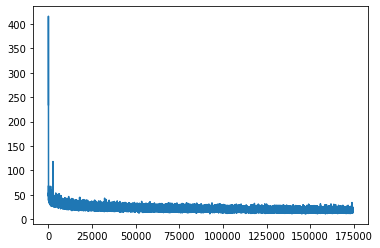

epoch: 94 	 step:0 	 loss: 16.61
epoch: 94 	 step:100 	 loss: 13.26
epoch: 94 	 step:200 	 loss: 16.52
epoch: 94 	 step:300 	 loss: 21.92
epoch: 94 	 step:400 	 loss: 16.31
epoch: 94 	 step:500 	 loss: 18.26
epoch: 94 	 step:600 	 loss: 15.78
epoch: 94 	 step:700 	 loss: 20.87
epoch: 94 	 step:800 	 loss: 16.68
epoch: 94 	 step:900 	 loss: 16.6
epoch: 94 	 step:1000 	 loss: 20.44
epoch: 94 	 step:1100 	 loss: 23.51
epoch: 94 	 step:1200 	 loss: 18.94
epoch: 94 	 step:1300 	 loss: 16.93
epoch: 94 	 step:1400 	 loss: 19.93
epoch: 94 	 step:1500 	 loss: 15.19
epoch: 94 	 step:1600 	 loss: 20.59
epoch: 94 	 step:1700 	 loss: 19.24
epoch: 94 	 step:1800 	 loss: 16.89


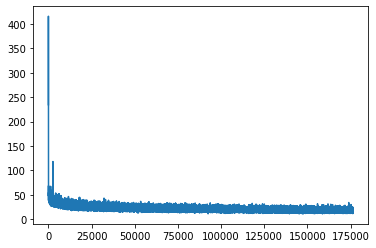

epoch: 95 	 step:0 	 loss: 16.4
epoch: 95 	 step:100 	 loss: 15.77
epoch: 95 	 step:200 	 loss: 17.14
epoch: 95 	 step:300 	 loss: 19.06
epoch: 95 	 step:400 	 loss: 20.34
epoch: 95 	 step:500 	 loss: 18.74
epoch: 95 	 step:600 	 loss: 23.27
epoch: 95 	 step:700 	 loss: 16.78
epoch: 95 	 step:800 	 loss: 17.43
epoch: 95 	 step:900 	 loss: 18.61
epoch: 95 	 step:1000 	 loss: 19.92
epoch: 95 	 step:1100 	 loss: 21.96
epoch: 95 	 step:1200 	 loss: 19.04
epoch: 95 	 step:1300 	 loss: 17.58
epoch: 95 	 step:1400 	 loss: 13.22
epoch: 95 	 step:1500 	 loss: 15.29
epoch: 95 	 step:1600 	 loss: 17.82
epoch: 95 	 step:1700 	 loss: 17.18
epoch: 95 	 step:1800 	 loss: 20.46


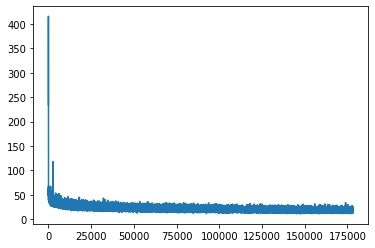

epoch: 96 	 step:0 	 loss: 15.46
epoch: 96 	 step:100 	 loss: 17.7
epoch: 96 	 step:200 	 loss: 14.33
epoch: 96 	 step:300 	 loss: 18.27
epoch: 96 	 step:400 	 loss: 20.18
epoch: 96 	 step:500 	 loss: 18.09
epoch: 96 	 step:600 	 loss: 20.91
epoch: 96 	 step:700 	 loss: 17.01
epoch: 96 	 step:800 	 loss: 20.13
epoch: 96 	 step:900 	 loss: 19.34
epoch: 96 	 step:1000 	 loss: 16.38
epoch: 96 	 step:1100 	 loss: 20.82
epoch: 96 	 step:1200 	 loss: 21.0
epoch: 96 	 step:1300 	 loss: 14.75
epoch: 96 	 step:1400 	 loss: 21.49
epoch: 96 	 step:1500 	 loss: 21.15
epoch: 96 	 step:1600 	 loss: 16.34
epoch: 96 	 step:1700 	 loss: 21.64
epoch: 96 	 step:1800 	 loss: 17.92


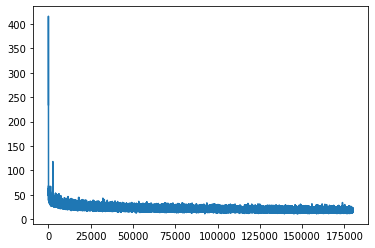

epoch: 97 	 step:0 	 loss: 17.35
epoch: 97 	 step:100 	 loss: 16.06
epoch: 97 	 step:200 	 loss: 15.46
epoch: 97 	 step:300 	 loss: 17.55
epoch: 97 	 step:400 	 loss: 16.98
epoch: 97 	 step:500 	 loss: 17.93
epoch: 97 	 step:600 	 loss: 14.45
epoch: 97 	 step:700 	 loss: 20.78
epoch: 97 	 step:800 	 loss: 18.89
epoch: 97 	 step:900 	 loss: 18.85
epoch: 97 	 step:1000 	 loss: 20.53
epoch: 97 	 step:1100 	 loss: 18.15
epoch: 97 	 step:1200 	 loss: 17.74
epoch: 97 	 step:1300 	 loss: 15.98
epoch: 97 	 step:1400 	 loss: 20.16
epoch: 97 	 step:1500 	 loss: 19.19
epoch: 97 	 step:1600 	 loss: 16.88
epoch: 97 	 step:1700 	 loss: 14.51
epoch: 97 	 step:1800 	 loss: 15.89


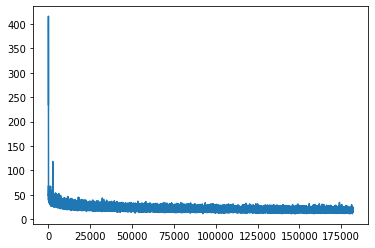

epoch: 98 	 step:0 	 loss: 17.58
epoch: 98 	 step:100 	 loss: 15.51
epoch: 98 	 step:200 	 loss: 16.93
epoch: 98 	 step:300 	 loss: 16.64
epoch: 98 	 step:400 	 loss: 15.49
epoch: 98 	 step:500 	 loss: 18.99
epoch: 98 	 step:600 	 loss: 16.35
epoch: 98 	 step:700 	 loss: 16.44
epoch: 98 	 step:800 	 loss: 15.95
epoch: 98 	 step:900 	 loss: 17.87
epoch: 98 	 step:1000 	 loss: 19.43
epoch: 98 	 step:1100 	 loss: 14.45
epoch: 98 	 step:1200 	 loss: 21.44
epoch: 98 	 step:1300 	 loss: 17.17
epoch: 98 	 step:1400 	 loss: 16.59
epoch: 98 	 step:1500 	 loss: 14.94
epoch: 98 	 step:1600 	 loss: 18.14
epoch: 98 	 step:1700 	 loss: 16.55
epoch: 98 	 step:1800 	 loss: 19.39


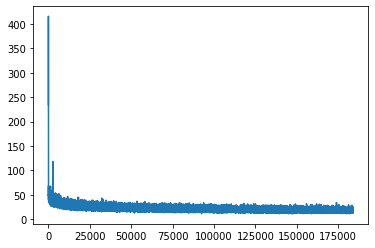

epoch: 99 	 step:0 	 loss: 19.92
epoch: 99 	 step:100 	 loss: 16.75
epoch: 99 	 step:200 	 loss: 18.43
epoch: 99 	 step:300 	 loss: 23.39
epoch: 99 	 step:400 	 loss: 16.92
epoch: 99 	 step:500 	 loss: 20.9
epoch: 99 	 step:600 	 loss: 18.78
epoch: 99 	 step:700 	 loss: 21.01
epoch: 99 	 step:800 	 loss: 18.08
epoch: 99 	 step:900 	 loss: 16.15
epoch: 99 	 step:1000 	 loss: 16.18
epoch: 99 	 step:1100 	 loss: 16.29
epoch: 99 	 step:1200 	 loss: 19.27
epoch: 99 	 step:1300 	 loss: 17.31
epoch: 99 	 step:1400 	 loss: 19.09
epoch: 99 	 step:1500 	 loss: 17.77
epoch: 99 	 step:1600 	 loss: 13.89
epoch: 99 	 step:1700 	 loss: 17.33
epoch: 99 	 step:1800 	 loss: 16.08


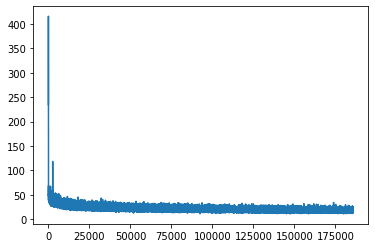

epoch: 100 	 step:0 	 loss: 16.43
epoch: 100 	 step:100 	 loss: 19.46
epoch: 100 	 step:200 	 loss: 19.44
epoch: 100 	 step:300 	 loss: 19.27
epoch: 100 	 step:400 	 loss: 21.55
epoch: 100 	 step:500 	 loss: 20.35
epoch: 100 	 step:600 	 loss: 21.28
epoch: 100 	 step:700 	 loss: 19.32
epoch: 100 	 step:800 	 loss: 19.92
epoch: 100 	 step:900 	 loss: 17.36
epoch: 100 	 step:1000 	 loss: 22.23
epoch: 100 	 step:1100 	 loss: 19.48
epoch: 100 	 step:1200 	 loss: 16.42
epoch: 100 	 step:1300 	 loss: 14.8
epoch: 100 	 step:1400 	 loss: 15.72
epoch: 100 	 step:1500 	 loss: 23.57
epoch: 100 	 step:1600 	 loss: 14.4
epoch: 100 	 step:1700 	 loss: 18.62
epoch: 100 	 step:1800 	 loss: 18.34


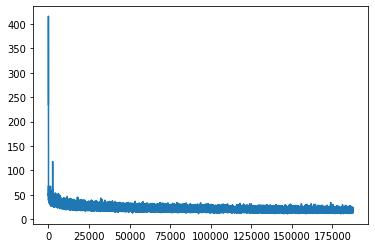

In [18]:
### TRAIN MODEL ###

num_epochs = 100

history = train_model(gen, opt, device, dataloader['train'], epochs=num_epochs)

In [19]:
def test_generator(model, device, testloader, one_batch=False):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        data = data.to(device=device)
        test_images.append(data.cpu().numpy())
        magn, _ = calc_fourier(data)
        out_phs = model(magn)
        out_ft = magn[..., None] * torch.stack([torch.cos(out_phs), torch.sin(out_phs)], dim=-1)
        out = torch.irfft(out_ft, 2, onesided=False)
        
        outputs.append(out.cpu().detach().numpy())
        if one_batch: break
    
    return np.concatenate(test_images), np.concatenate(outputs)

In [20]:
# Calculate test predictions #

test_original, test_predicted = test_generator(gen, device, dataloader['test'])
print(test_original.shape)
print(test_predicted.shape)

(8000, 1, 28, 28)
(8000, 1, 28, 28)


Produces negative values!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


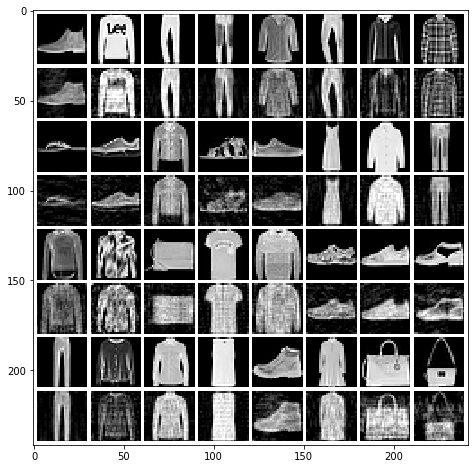

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


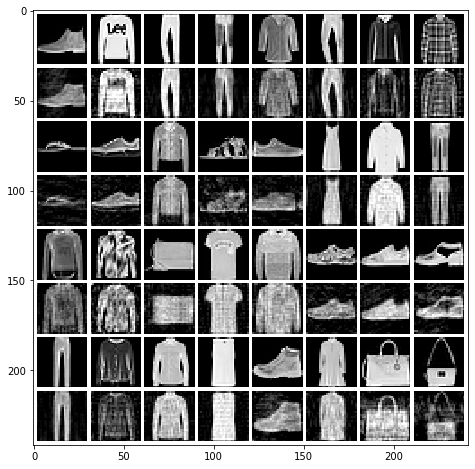

In [21]:
# Print predictions #
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    test_predicted[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8), file="../out/Fashion/end-to-end/phase-prediction/fourier-dist.png")

print("Registered:")
results_reg = register_croco(test_predicted[:32], test_original[:32])
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/Fashion/end-to-end/phase-prediction/fourier-dist-reg.png")

In [22]:
# Benchmark test predictions #

benchmark(pred=test_predicted[:1024], true=test_original[:1024], check_all=True)

Signal error:
  MSE: 0.02681497590060644, std: 0.021216765290729973
  MAE: 0.11582672061922494, std: 0.04621263992434948
  SSIM: 0.5973034774948753, std: 0.1604952663880052
  Sharpness: 0.18420048963760688, std: 0.061427378814702775
  PhCo-MSE: 0.02856034486671888, std: 0.03144003962350756
  PhCo-MAE: 0.11796653842611704, std: 0.054858070852889566
  PhCo-SSIM: 0.5948027455870515, std: 0.17579023869016255
  CroCo-MSE: 0.024050868382119006, std: 0.017491431749427303
  CroCo-MAE: 0.11190073988109361, std: 0.04227177531264199
  CroCo-SSIM: 0.61497268010797, std: 0.1425839175691925

Magnitude error:
  MSE Magnitude: 0.15478755177463138, std: 0.3942555578349897

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [-1.62, 1.66] - should be in [0, 1]

Markdown table values:
 0.02681 | 0.1158 | 0.5973 | 0.1842 | 0.02856 | 0.1180 | 0.5948 | 0.02405 | 0.1119 | 0.6150 | 0.1548 |


## Evaluation for different FC  (1024 samples)

#### Simple L2 squared loss

| Nr | Loss | Size | epochs| MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | L2 | 2048 | 100 | 0.09214 | 0.2154 | 0.3693 | 0.2129 | 0.1095 | 0.2385 | 0.3147 | 0.05648 | 0.1731 | 0.4329 | 0.01854 |

Signal error:
  MSE: 0.09213607336414498, std: 0.09195137242537284
  MAE: 0.21544245020777453, std: 0.11425811815121525
  SSIM: 0.3693095558917151, std: 0.20650220099710764
  Sharpness: 0.2129355471106003, std: 0.05883183839731661
  PhCo-MSE: 0.10953122576120222, std: 0.10158480065543135
  PhCo-MAE: 0.23849295981926844, std: 0.12319403211111792
  PhCo-SSIM: 0.3147278330506624, std: 0.24211248501664664
  CroCo-MSE: 0.056482310526007495, std: 0.03507872575567187
  CroCo-MAE: 0.17312558776757214, std: 0.0593940078500203
  CroCo-SSIM: 0.43292194724639743, std: 0.144196148448554

Magnitude error:
  MSE Magnitude: 0.01854351816953955, std: 0.03972265207003048

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [-1.10, 5.04] - should be in [0, 1]

#### Fourier L2 phase dist

| Nr | Loss | Size | epochs| MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | Fourier dist | 2048 | 100 | 0.02681 | 0.1158 | 0.5973 | 0.1842 | 0.02856 | 0.1180 | 0.5948 | 0.02405 | 0.1119 | 0.6150 | 0.1548 |

Signal error:
  MSE: 0.02681497590060644, std: 0.021216765290729973
  MAE: 0.11582672061922494, std: 0.04621263992434948
  SSIM: 0.5973034774948753, std: 0.1604952663880052
  Sharpness: 0.18420048963760688, std: 0.061427378814702775
  PhCo-MSE: 0.02856034486671888, std: 0.03144003962350756
  PhCo-MAE: 0.11796653842611704, std: 0.054858070852889566
  PhCo-SSIM: 0.5948027455870515, std: 0.17579023869016255
  CroCo-MSE: 0.024050868382119006, std: 0.017491431749427303
  CroCo-MAE: 0.11190073988109361, std: 0.04227177531264199
  CroCo-SSIM: 0.61497268010797, std: 0.1425839175691925

Magnitude error:
  MSE Magnitude: 0.15478755177463138, std: 0.3942555578349897

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [-1.62, 1.66] - should be in [0, 1]
